<a href="https://colab.research.google.com/github/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression with Transformer

- Yongyang Liu

## Library

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F


In [2]:
# Path to save the trained model
Path = os.getcwd()
PATH = "Trained_model/Transformer.pth"

#CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


## Data Loading

In [3]:
x = np.loadtxt('Sample_data/input.txt', delimiter='\t')
print(x.shape)

y = np.loadtxt('Sample_data/output.txt', delimiter='\t')
print(y.shape)

time_len    = 320                                   #time length for sample data for each vehicle           
veh_len     = 5                                     #vehicle length
seq_length  = 5                                     #Input sequency lenght, should not be too long. Use the past seq-length sample data to predict the next step state

time_length = len(x)                                #time length for total sample data
num_veh     = int(time_length/time_len)             #number of vehicles in sample data
print(num_veh)

(288000, 3)
(288000,)
900


## Data Processing

In [4]:
training_size = 700
validation_size = 100
testing_size = 100

dataX       = Variable(torch.Tensor(np.array(x)))   #Input data
y=y.reshape(-1,1)
dataY       = Variable(torch.Tensor(np.array(y)))   #Output target
sample_len  = time_len - seq_length                 # sample length from each vehicle

############ Training #############
trainX      = Variable(torch.empty(training_size*sample_len, seq_length, 3))
trainY      = Variable(torch.empty(training_size*sample_len, seq_length, 1))

for j in range(training_size): 
    for i in range(sample_len):
        #input data
        trainX[j*sample_len+i,0:seq_length] = dataX[j*time_len+i : j*time_len+i+seq_length] 
        #output target
        trainY[j*sample_len+i,0:seq_length] = dataY[j*time_len+i+1: j*time_len+i+seq_length+1]    
print(trainX.shape)
print(trainY.shape)

############ test #############
validX = Variable(torch.empty(validation_size*sample_len, seq_length, 3))
validY = Variable(torch.empty(validation_size*sample_len, seq_length, 1))
for j in range(validation_size): 
    for i in range(sample_len):
        #input data
        j_0 = j + training_size
        validX[j*sample_len+i,0:seq_length] = dataX[j_0*time_len+i : j_0*time_len+i+seq_length] 
        #output target
        validY[j*sample_len+i,0:seq_length] = dataY[j_0*time_len+i+1: j_0*time_len+i+seq_length+1]      
print(validX.shape)
print(validY.shape)


############ test #############
testX = Variable(torch.empty(testing_size*sample_len, seq_length, 3))
testY = Variable(torch.empty(testing_size*sample_len, seq_length, 1))
for j in range(testing_size): 
    for i in range(sample_len):
        #input data
        j_0 = j + training_size + validation_size
        testX[j*sample_len+i,0:seq_length] = dataX[j_0*time_len+i : j_0*time_len+i+seq_length] 
        #output target
        testY[j*sample_len+i,0:seq_length] = dataY[j_0*time_len+i+1: j_0*time_len+i+seq_length+1]      

print(testX.shape)
print(testY.shape)

# CUDA
trainX = trainX.to(device)
trainY = trainY.to(device)
validX = validX.to(device)
validY = validY.to(device)
testX = testX.to(device)
testY = testY.to(device)


torch.Size([220500, 5, 3])
torch.Size([220500, 5, 1])
torch.Size([31500, 5, 3])
torch.Size([31500, 5, 1])
torch.Size([31500, 5, 3])
torch.Size([31500, 5, 1])


## Model

In [5]:
class TRANSFORMER(nn.Module):

    def __init__(self, 
        input_size, 
        output_size,
        embedding_dims,
        fc_size,
        input_seq_size,
        output_seq_size): 
        
        super(TRANSFORMER, self).__init__()
        self.input_size = input_size
        self.output_size= output_size
        self.embedding_dims = embedding_dims
        self.fc_size = fc_size
        self.input_seq_size=input_seq_size
        self.output_seq_size=output_seq_size-1
         
        self.embedding_in = nn.Linear(self.input_size, self.embedding_dims)
        self.embedding_out= nn.Linear(self.output_size, self.embedding_dims)
        self.embedding_position_in = nn.Embedding(self.input_seq_size, self.embedding_dims)
        self.embedding_position_out= nn.Embedding(self.output_seq_size, self.embedding_dims)
        
        self.transformer = nn.Transformer(
            d_model=self.embedding_dims,   
            nhead=2,
            num_encoder_layers=1,
            num_decoder_layers=1, 
            dim_feedforward=128, 
            dropout=0.1, 
            activation='relu'
        )
        
        self.fc1 = nn.Linear(self.embedding_dims, self.fc_size)
        self.fc2 = nn.Linear(int(self.fc_size), int(self.fc_size/2)) 
        self.fc3 = nn.Linear(int(self.fc_size/2), self.output_size)

    def forward(self, x,y):
        out_x = self.embedding_in(x)
        out_y = self.embedding_out(y)
      
        out_x +=self.embedding_position_in(torch.tensor(list(range(self.input_seq_size))).to(device))
        out_y +=self.embedding_position_out(torch.tensor(list(range(self.output_seq_size))).to(device))
        
        out_x = out_x.permute(1,0,2)
        out_y = out_y.permute(1,0,2)
            
        out = self.transformer(out_x,out_y)
        out = out.permute(1,0,2)
        
        out = out[:,self.output_seq_size-1,:]    # choose the final value
        out = out.reshape(-1, self.embedding_dims)
        out = F.relu((self.fc1(out)))
        out = F.relu((self.fc2(out)))
        out = self.fc3(out)
        
        return out

## Training

Model's state_dict:
embedding_in.weight 	 torch.Size([128, 3])
embedding_in.bias 	 torch.Size([128])
embedding_out.weight 	 torch.Size([128, 1])
embedding_out.bias 	 torch.Size([128])
embedding_position_in.weight 	 torch.Size([5, 128])
embedding_position_out.weight 	 torch.Size([4, 128])
transformer.encoder.layers.0.self_attn.in_proj_weight 	 torch.Size([384, 128])
transformer.encoder.layers.0.self_attn.in_proj_bias 	 torch.Size([384])
transformer.encoder.layers.0.self_attn.out_proj.weight 	 torch.Size([128, 128])
transformer.encoder.layers.0.self_attn.out_proj.bias 	 torch.Size([128])
transformer.encoder.layers.0.linear1.weight 	 torch.Size([128, 128])
transformer.encoder.layers.0.linear1.bias 	 torch.Size([128])
transformer.encoder.layers.0.linear2.weight 	 torch.Size([128, 128])
transformer.encoder.layers.0.linear2.bias 	 torch.Size([128])
transformer.encoder.layers.0.norm1.weight 	 torch.Size([128])
transformer.encoder.layers.0.norm1.bias 	 torch.Size([128])
transformer.encoder.lay

C:\Users\yliu3119\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
C:\Users\yliu3119\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


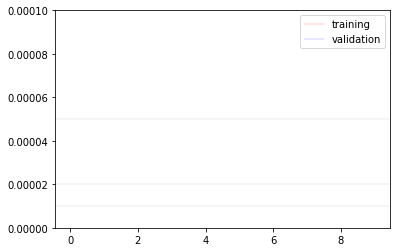

Epoch: 1, loss_train: 0.007044704165, loss_valid: 0.007093797438, best loss: 0.006849648431
Epoch: 2, loss_train: 0.006627413444, loss_valid: 0.006513181608, best loss: 0.006498205941
Epoch: 3, loss_train: 0.005412629806, loss_valid: 0.005192691926, best loss: 0.005192691926
Epoch: 4, loss_train: 0.003490058705, loss_valid: 0.002156999428, best loss: 0.002156999428
Epoch: 5, loss_train: 0.001143667265, loss_valid: 0.001254676259, best loss: 0.001141341520
Epoch: 6, loss_train: 0.000893601915, loss_valid: 0.000928525464, best loss: 0.000872708217
Epoch: 7, loss_train: 0.000673897273, loss_valid: 0.000666824460, best loss: 0.000666824460
Epoch: 8, loss_train: 0.000547003932, loss_valid: 0.000526960008, best loss: 0.000526960008
Epoch: 9, loss_train: 0.000432906148, loss_valid: 0.000422412093, best loss: 0.000422412093
Epoch: 10, loss_train: 0.000372110109, loss_valid: 0.000367510656, best loss: 0.000365087821
Epoch L1 regularization 0.00000019


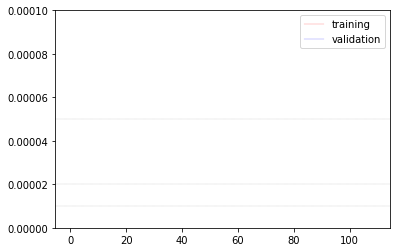

Epoch: 11, loss_train: 0.000316257298, loss_valid: 0.000311814860, best loss: 0.000307319366
Epoch: 12, loss_train: 0.000282020803, loss_valid: 0.000276747771, best loss: 0.000272208446
Epoch: 13, loss_train: 0.000252862897, loss_valid: 0.000249561534, best loss: 0.000249561534
Epoch: 14, loss_train: 0.000230682490, loss_valid: 0.000232916675, best loss: 0.000230148507
Epoch: 15, loss_train: 0.000215366294, loss_valid: 0.000215822889, best loss: 0.000213051680
Epoch: 16, loss_train: 0.000205346543, loss_valid: 0.000198755006, best loss: 0.000198755006
Epoch: 17, loss_train: 0.000193847212, loss_valid: 0.000188057951, best loss: 0.000188057951
Epoch: 18, loss_train: 0.000189530198, loss_valid: 0.000181780561, best loss: 0.000181780561
Epoch: 19, loss_train: 0.000181806143, loss_valid: 0.000176302594, best loss: 0.000174209170
Epoch: 20, loss_train: 0.000171487409, loss_valid: 0.000175249632, best loss: 0.000167179445
Epoch L1 regularization 0.00000019


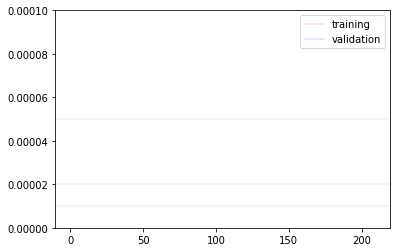

Epoch: 21, loss_train: 0.000159669231, loss_valid: 0.000161979595, best loss: 0.000161979595
Epoch: 22, loss_train: 0.000168791754, loss_valid: 0.000161284814, best loss: 0.000157836374
Epoch: 23, loss_train: 0.000152233944, loss_valid: 0.000149144311, best loss: 0.000149144311
Epoch: 24, loss_train: 0.000147808110, loss_valid: 0.000143371435, best loss: 0.000143371435
Epoch: 25, loss_train: 0.000143423313, loss_valid: 0.000144469130, best loss: 0.000138871997
Epoch: 26, loss_train: 0.000165050064, loss_valid: 0.000158363226, best loss: 0.000138871997
Epoch: 27, loss_train: 0.000139722426, loss_valid: 0.000134195376, best loss: 0.000134195376
Epoch: 28, loss_train: 0.000138818345, loss_valid: 0.000138513031, best loss: 0.000130657048
Epoch: 29, loss_train: 0.000128839485, loss_valid: 0.000131475550, best loss: 0.000127405830
Epoch: 30, loss_train: 0.000145122642, loss_valid: 0.000149225336, best loss: 0.000126777508
Epoch L1 regularization 0.00000019


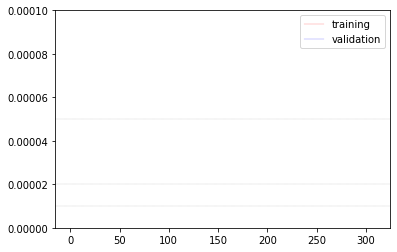

Epoch: 31, loss_train: 0.000130799919, loss_valid: 0.000122208323, best loss: 0.000121453209
Epoch: 32, loss_train: 0.000123575708, loss_valid: 0.000120588491, best loss: 0.000118417418
Epoch: 33, loss_train: 0.000118659242, loss_valid: 0.000112176982, best loss: 0.000112176982
Epoch: 34, loss_train: 0.000123418882, loss_valid: 0.000115534618, best loss: 0.000112176982
Epoch: 35, loss_train: 0.000117911026, loss_valid: 0.000118527038, best loss: 0.000112176982
Epoch: 36, loss_train: 0.000111118199, loss_valid: 0.000111602269, best loss: 0.000110763991
Epoch: 37, loss_train: 0.000188134509, loss_valid: 0.000203335905, best loss: 0.000110763991
Epoch: 38, loss_train: 0.000116692994, loss_valid: 0.000139784403, best loss: 0.000109649751
Epoch: 39, loss_train: 0.000123099497, loss_valid: 0.000118295386, best loss: 0.000107915243
Epoch: 40, loss_train: 0.000113382943, loss_valid: 0.000105224601, best loss: 0.000104419451
Epoch L1 regularization 0.00000019


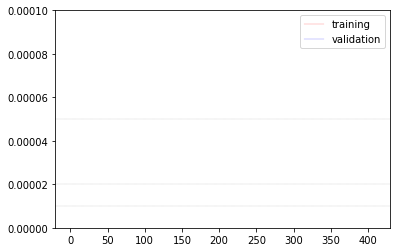

Epoch: 41, loss_train: 0.000114498696, loss_valid: 0.000107291038, best loss: 0.000103523693
Epoch: 42, loss_train: 0.000104445266, loss_valid: 0.000102792103, best loss: 0.000101728423
Epoch: 43, loss_train: 0.000101008329, loss_valid: 0.000100520359, best loss: 0.000098264449
Epoch: 44, loss_train: 0.000100221187, loss_valid: 0.000098017983, best loss: 0.000097933516
Epoch: 45, loss_train: 0.000099984158, loss_valid: 0.000096142074, best loss: 0.000095719581
Epoch: 46, loss_train: 0.000104187420, loss_valid: 0.000100168632, best loss: 0.000095616451
Epoch: 47, loss_train: 0.000108910448, loss_valid: 0.000105642685, best loss: 0.000094877694
Epoch: 48, loss_train: 0.000105891260, loss_valid: 0.000105920735, best loss: 0.000094426119
Epoch: 49, loss_train: 0.000105887215, loss_valid: 0.000100725658, best loss: 0.000091811344
Epoch: 50, loss_train: 0.000096025789, loss_valid: 0.000094936586, best loss: 0.000089850422
Epoch L1 regularization 0.00000019


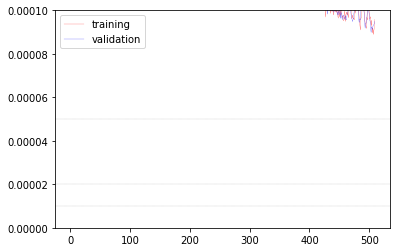

Epoch: 51, loss_train: 0.000094587151, loss_valid: 0.000090892754, best loss: 0.000089850422
Epoch: 52, loss_train: 0.000092275273, loss_valid: 0.000089776950, best loss: 0.000089030538
Epoch: 53, loss_train: 0.000132817964, loss_valid: 0.000129002437, best loss: 0.000089030538
Epoch: 54, loss_train: 0.000100684483, loss_valid: 0.000089471236, best loss: 0.000088920126
Epoch: 55, loss_train: 0.000090785048, loss_valid: 0.000093917552, best loss: 0.000085913074
Epoch: 56, loss_train: 0.000097527634, loss_valid: 0.000093408373, best loss: 0.000085913074
Epoch: 57, loss_train: 0.000086449654, loss_valid: 0.000086397675, best loss: 0.000085343134
Epoch: 58, loss_train: 0.000097910532, loss_valid: 0.000098564269, best loss: 0.000083436542
Epoch: 59, loss_train: 0.000087641769, loss_valid: 0.000087854089, best loss: 0.000083187544
Epoch: 60, loss_train: 0.000090706861, loss_valid: 0.000090721915, best loss: 0.000080574042
Epoch L1 regularization 0.00000019


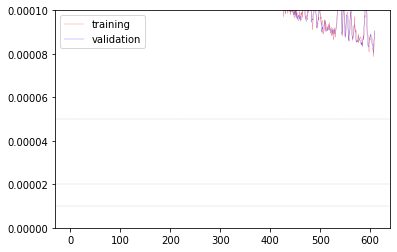

Epoch: 61, loss_train: 0.000085170504, loss_valid: 0.000084797939, best loss: 0.000080574042
Epoch: 62, loss_train: 0.000084565101, loss_valid: 0.000080390142, best loss: 0.000079962287
Epoch: 63, loss_train: 0.000084228188, loss_valid: 0.000081883605, best loss: 0.000078787394
Epoch: 64, loss_train: 0.000096791402, loss_valid: 0.000094319781, best loss: 0.000078787394
Epoch: 65, loss_train: 0.000083232400, loss_valid: 0.000082061968, best loss: 0.000078232813
Epoch: 66, loss_train: 0.000081742546, loss_valid: 0.000079309553, best loss: 0.000077130229
Epoch: 67, loss_train: 0.000079753183, loss_valid: 0.000076879660, best loss: 0.000076879660
Epoch: 68, loss_train: 0.000090280286, loss_valid: 0.000094585193, best loss: 0.000076083379
Epoch: 69, loss_train: 0.000078383135, loss_valid: 0.000081892082, best loss: 0.000076083379
Epoch: 70, loss_train: 0.000083321866, loss_valid: 0.000079014717, best loss: 0.000074652824
Epoch L1 regularization 0.00000019


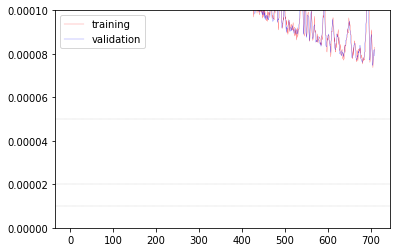

Epoch: 71, loss_train: 0.000075829834, loss_valid: 0.000074905307, best loss: 0.000073586678
Epoch: 72, loss_train: 0.000075762684, loss_valid: 0.000074512194, best loss: 0.000073586678
Epoch: 73, loss_train: 0.000076159937, loss_valid: 0.000072704155, best loss: 0.000072458024
Epoch: 74, loss_train: 0.000081790313, loss_valid: 0.000080325066, best loss: 0.000072458024
Epoch: 75, loss_train: 0.000075000069, loss_valid: 0.000071650662, best loss: 0.000071303191
Epoch: 76, loss_train: 0.000073832838, loss_valid: 0.000072577532, best loss: 0.000070344424
Epoch: 77, loss_train: 0.000112781214, loss_valid: 0.000110793437, best loss: 0.000070344424
Epoch: 78, loss_train: 0.000087586472, loss_valid: 0.000081496910, best loss: 0.000070098788
Epoch: 79, loss_train: 0.000071725546, loss_valid: 0.000073485317, best loss: 0.000069515962
Epoch: 80, loss_train: 0.000077320998, loss_valid: 0.000073642099, best loss: 0.000069156180
Epoch L1 regularization 0.00000019


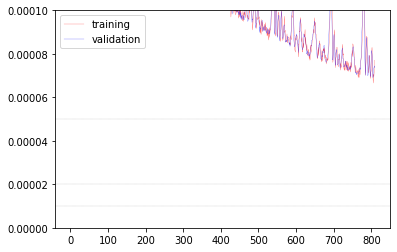

Epoch: 81, loss_train: 0.000072489362, loss_valid: 0.000070747970, best loss: 0.000068780406
Epoch: 82, loss_train: 0.000071059963, loss_valid: 0.000068403482, best loss: 0.000066962515
Epoch: 83, loss_train: 0.000076392476, loss_valid: 0.000075723423, best loss: 0.000066555192
Epoch: 84, loss_train: 0.000068731286, loss_valid: 0.000067905698, best loss: 0.000066555192
Epoch: 85, loss_train: 0.000082433136, loss_valid: 0.000079075762, best loss: 0.000066555192
Epoch: 86, loss_train: 0.000070799520, loss_valid: 0.000072570656, best loss: 0.000065504581
Epoch: 87, loss_train: 0.000068839632, loss_valid: 0.000067017463, best loss: 0.000065499487
Epoch: 88, loss_train: 0.000068444402, loss_valid: 0.000065837565, best loss: 0.000065499487
Epoch: 89, loss_train: 0.000076980206, loss_valid: 0.000073433956, best loss: 0.000064436128
Epoch: 90, loss_train: 0.000071059148, loss_valid: 0.000067761845, best loss: 0.000064436128
Epoch L1 regularization 0.00000019


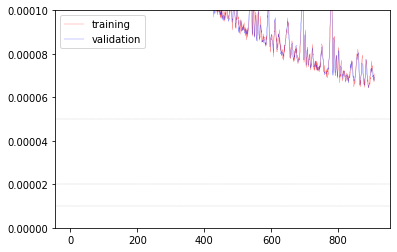

Epoch: 91, loss_train: 0.000066238070, loss_valid: 0.000065961627, best loss: 0.000063230982
Epoch: 92, loss_train: 0.000066426503, loss_valid: 0.000067197332, best loss: 0.000062702195
Epoch: 93, loss_train: 0.000072910909, loss_valid: 0.000072377072, best loss: 0.000062702195
Epoch: 94, loss_train: 0.000080569072, loss_valid: 0.000075806420, best loss: 0.000062702195
Epoch: 95, loss_train: 0.000076440389, loss_valid: 0.000074355296, best loss: 0.000061809609
Epoch: 96, loss_train: 0.000068966874, loss_valid: 0.000069193775, best loss: 0.000061566505
Epoch: 97, loss_train: 0.000068563095, loss_valid: 0.000066198139, best loss: 0.000061566505
Epoch: 98, loss_train: 0.000065989399, loss_valid: 0.000063606014, best loss: 0.000061566505
Epoch: 99, loss_train: 0.000063579530, loss_valid: 0.000062906460, best loss: 0.000059756148
Epoch: 100, loss_train: 0.000084109932, loss_valid: 0.000077778590, best loss: 0.000059756148
Epoch L1 regularization 0.00000019


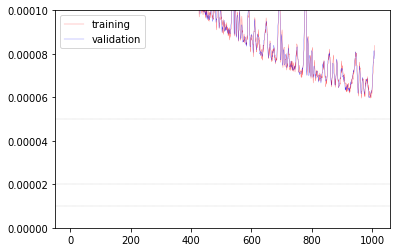

Epoch: 101, loss_train: 0.000065261876, loss_valid: 0.000064587199, best loss: 0.000058945512
Epoch: 102, loss_train: 0.000060964339, loss_valid: 0.000059150487, best loss: 0.000058945512
Epoch: 103, loss_train: 0.000063922809, loss_valid: 0.000060625382, best loss: 0.000058429159
Epoch: 104, loss_train: 0.000073062991, loss_valid: 0.000075927346, best loss: 0.000058429159
Epoch: 105, loss_train: 0.000059773938, loss_valid: 0.000057751749, best loss: 0.000057751749
Epoch: 106, loss_train: 0.000059469967, loss_valid: 0.000058290771, best loss: 0.000057751749
Epoch: 107, loss_train: 0.000060975668, loss_valid: 0.000058809987, best loss: 0.000056914192
Epoch: 108, loss_train: 0.000057095116, loss_valid: 0.000056500961, best loss: 0.000056500961
Epoch: 109, loss_train: 0.000059697424, loss_valid: 0.000056814675, best loss: 0.000056239576
Epoch: 110, loss_train: 0.000068795052, loss_valid: 0.000072334959, best loss: 0.000056120134
Epoch L1 regularization 0.00000019


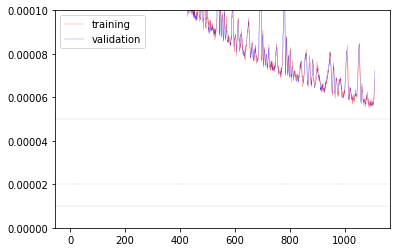

Epoch: 111, loss_train: 0.000059100941, loss_valid: 0.000064482403, best loss: 0.000056120134
Epoch: 112, loss_train: 0.000058705078, loss_valid: 0.000060019192, best loss: 0.000056120134
Epoch: 113, loss_train: 0.000057848436, loss_valid: 0.000061356004, best loss: 0.000056120134
Epoch: 114, loss_train: 0.000055256936, loss_valid: 0.000056447090, best loss: 0.000055736917
Epoch: 115, loss_train: 0.000059671151, loss_valid: 0.000057362795, best loss: 0.000053792879
Epoch: 116, loss_train: 0.000056218145, loss_valid: 0.000054746204, best loss: 0.000053792879
Epoch: 117, loss_train: 0.000056973950, loss_valid: 0.000055543100, best loss: 0.000053792879
Epoch: 118, loss_train: 0.000054620374, loss_valid: 0.000052605286, best loss: 0.000052605286
Epoch: 119, loss_train: 0.000055565306, loss_valid: 0.000053293257, best loss: 0.000052605286
Epoch: 120, loss_train: 0.000058060719, loss_valid: 0.000056648929, best loss: 0.000052605286
Epoch L1 regularization 0.00000019


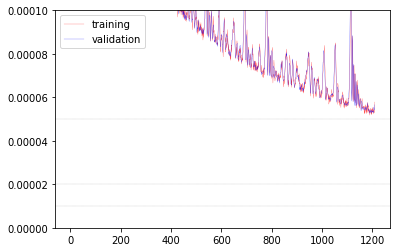

Epoch: 121, loss_train: 0.000085149950, loss_valid: 0.000084080610, best loss: 0.000052605286
Epoch: 122, loss_train: 0.000066996829, loss_valid: 0.000061746658, best loss: 0.000052605286
Epoch: 123, loss_train: 0.000056090059, loss_valid: 0.000052482992, best loss: 0.000052482992
Epoch: 124, loss_train: 0.000053557254, loss_valid: 0.000052202286, best loss: 0.000051404946
Epoch: 125, loss_train: 0.000053073691, loss_valid: 0.000051936604, best loss: 0.000051404946
Epoch: 126, loss_train: 0.000052445910, loss_valid: 0.000051152510, best loss: 0.000051057425
Epoch: 127, loss_train: 0.000057037309, loss_valid: 0.000058596288, best loss: 0.000050700579
Epoch: 128, loss_train: 0.000087212211, loss_valid: 0.000060017046, best loss: 0.000050700579
Epoch: 129, loss_train: 0.000067394685, loss_valid: 0.000059302656, best loss: 0.000050700579
Epoch: 130, loss_train: 0.000058473055, loss_valid: 0.000058853402, best loss: 0.000050700579
Epoch L1 regularization 0.00000019


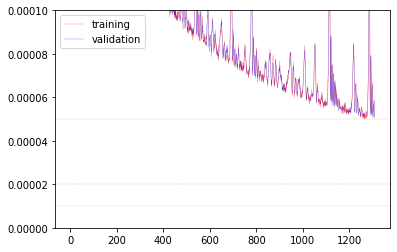

Epoch: 131, loss_train: 0.000051622541, loss_valid: 0.000050205686, best loss: 0.000050205686
Epoch: 132, loss_train: 0.000051307914, loss_valid: 0.000050812854, best loss: 0.000049620357
Epoch: 133, loss_train: 0.000050923638, loss_valid: 0.000051754276, best loss: 0.000049585320
Epoch: 134, loss_train: 0.000052871532, loss_valid: 0.000050463233, best loss: 0.000049585320
Epoch: 135, loss_train: 0.000052697957, loss_valid: 0.000050554096, best loss: 0.000048692924
Epoch: 136, loss_train: 0.000056200344, loss_valid: 0.000053035608, best loss: 0.000048692924
Epoch: 137, loss_train: 0.000049330862, loss_valid: 0.000049133567, best loss: 0.000048692924
Epoch: 138, loss_train: 0.000066652487, loss_valid: 0.000070618349, best loss: 0.000048286605
Epoch: 139, loss_train: 0.000058281228, loss_valid: 0.000061209132, best loss: 0.000048286605
Epoch: 140, loss_train: 0.000052693449, loss_valid: 0.000052204639, best loss: 0.000047800717
Epoch L1 regularization 0.00000019


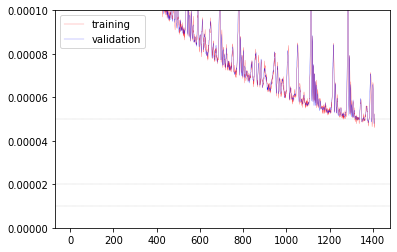

Epoch: 141, loss_train: 0.000054372525, loss_valid: 0.000053336593, best loss: 0.000047619033
Epoch: 142, loss_train: 0.000051335162, loss_valid: 0.000052134659, best loss: 0.000047230453
Epoch: 143, loss_train: 0.000049180497, loss_valid: 0.000046287692, best loss: 0.000046287692
Epoch: 144, loss_train: 0.000060323106, loss_valid: 0.000059946160, best loss: 0.000046287692
Epoch: 145, loss_train: 0.000049561426, loss_valid: 0.000046417150, best loss: 0.000046287692
Epoch: 146, loss_train: 0.000049579616, loss_valid: 0.000046721845, best loss: 0.000046093821
Epoch: 147, loss_train: 0.000047475271, loss_valid: 0.000045542540, best loss: 0.000045542540
Epoch: 148, loss_train: 0.000049569018, loss_valid: 0.000048433525, best loss: 0.000045542540
Epoch: 149, loss_train: 0.000062287072, loss_valid: 0.000068804562, best loss: 0.000045542540
Epoch: 150, loss_train: 0.000048316739, loss_valid: 0.000050759121, best loss: 0.000045542540
Epoch L1 regularization 0.00000019


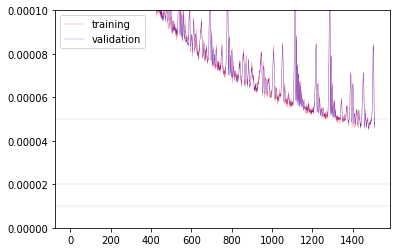

Epoch: 151, loss_train: 0.000049549897, loss_valid: 0.000047514684, best loss: 0.000045410430
Epoch: 152, loss_train: 0.000048388258, loss_valid: 0.000045219862, best loss: 0.000045083489
Epoch: 153, loss_train: 0.000046808273, loss_valid: 0.000045190336, best loss: 0.000043861783
Epoch: 154, loss_train: 0.000055269749, loss_valid: 0.000054017019, best loss: 0.000043861783
Epoch: 155, loss_train: 0.000045730969, loss_valid: 0.000044034961, best loss: 0.000043861783
Epoch: 156, loss_train: 0.000045259610, loss_valid: 0.000044297722, best loss: 0.000043861783
Epoch: 157, loss_train: 0.000054602675, loss_valid: 0.000063953739, best loss: 0.000043582611
Epoch: 158, loss_train: 0.000086742693, loss_valid: 0.000100315927, best loss: 0.000043582611
Epoch: 159, loss_train: 0.000054390588, loss_valid: 0.000046295358, best loss: 0.000043582611
Epoch: 160, loss_train: 0.000052746142, loss_valid: 0.000050712799, best loss: 0.000043582611
Epoch L1 regularization 0.00000019


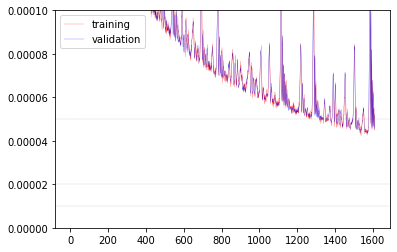

Epoch: 161, loss_train: 0.000046311787, loss_valid: 0.000044421002, best loss: 0.000043582611
Epoch: 162, loss_train: 0.000043573895, loss_valid: 0.000043258733, best loss: 0.000043258733
Epoch: 163, loss_train: 0.000045180528, loss_valid: 0.000043663160, best loss: 0.000042194231
Epoch: 164, loss_train: 0.000044270924, loss_valid: 0.000043246157, best loss: 0.000042194231
Epoch: 165, loss_train: 0.000044052889, loss_valid: 0.000042247084, best loss: 0.000042044430
Epoch: 166, loss_train: 0.000043952190, loss_valid: 0.000042218238, best loss: 0.000041924217
Epoch: 167, loss_train: 0.000046052148, loss_valid: 0.000044639728, best loss: 0.000041686384
Epoch: 168, loss_train: 0.000042947759, loss_valid: 0.000041486532, best loss: 0.000040746319
Epoch: 169, loss_train: 0.000054421533, loss_valid: 0.000060874510, best loss: 0.000040746319
Epoch: 170, loss_train: 0.000048748607, loss_valid: 0.000054718621, best loss: 0.000040746319
Epoch L1 regularization 0.00000019


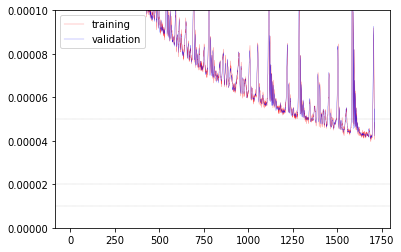

Epoch: 171, loss_train: 0.000043517724, loss_valid: 0.000041263647, best loss: 0.000040746319
Epoch: 172, loss_train: 0.000045316810, loss_valid: 0.000041118881, best loss: 0.000040416548
Epoch: 173, loss_train: 0.000042555406, loss_valid: 0.000041569634, best loss: 0.000040416548
Epoch: 174, loss_train: 0.000043531280, loss_valid: 0.000041505657, best loss: 0.000039965293
Epoch: 175, loss_train: 0.000043752570, loss_valid: 0.000042650234, best loss: 0.000039965293
Epoch: 176, loss_train: 0.000065409266, loss_valid: 0.000060745355, best loss: 0.000039965293
Epoch: 177, loss_train: 0.000046329253, loss_valid: 0.000043449552, best loss: 0.000039965293
Epoch: 178, loss_train: 0.000042010361, loss_valid: 0.000040040690, best loss: 0.000039965293
Epoch: 179, loss_train: 0.000043821201, loss_valid: 0.000041687399, best loss: 0.000039736584
Epoch: 180, loss_train: 0.000040851501, loss_valid: 0.000039517836, best loss: 0.000039062445
Epoch L1 regularization 0.00000019


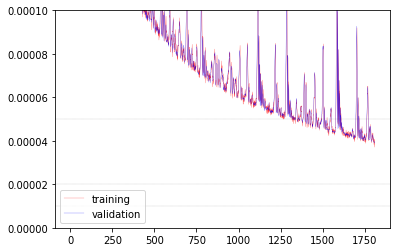

Epoch: 181, loss_train: 0.000100397498, loss_valid: 0.000127799824, best loss: 0.000039062445
Epoch: 182, loss_train: 0.000042299900, loss_valid: 0.000052693194, best loss: 0.000039062445
Epoch: 183, loss_train: 0.000048945923, loss_valid: 0.000048850023, best loss: 0.000039062445
Epoch: 184, loss_train: 0.000043590288, loss_valid: 0.000040216393, best loss: 0.000039062445
Epoch: 185, loss_train: 0.000042050568, loss_valid: 0.000039781637, best loss: 0.000038918839
Epoch: 186, loss_train: 0.000039630224, loss_valid: 0.000038490864, best loss: 0.000038163238
Epoch: 187, loss_train: 0.000040154908, loss_valid: 0.000038095783, best loss: 0.000037792342
Epoch: 188, loss_train: 0.000042646854, loss_valid: 0.000042006723, best loss: 0.000037792342
Epoch: 189, loss_train: 0.000056883637, loss_valid: 0.000053136697, best loss: 0.000037792342
Epoch: 190, loss_train: 0.000041631229, loss_valid: 0.000039409078, best loss: 0.000037792342
Epoch L1 regularization 0.00000019


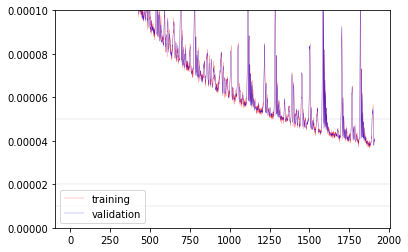

Epoch: 191, loss_train: 0.000039816914, loss_valid: 0.000038281836, best loss: 0.000037317834
Epoch: 192, loss_train: 0.000039330724, loss_valid: 0.000037821672, best loss: 0.000037317834
Epoch: 193, loss_train: 0.000039859071, loss_valid: 0.000041127125, best loss: 0.000037200774
Epoch: 194, loss_train: 0.000044519122, loss_valid: 0.000098243952, best loss: 0.000037200774
Epoch: 195, loss_train: 0.000057119742, loss_valid: 0.000042170170, best loss: 0.000037200774
Epoch: 196, loss_train: 0.000046313551, loss_valid: 0.000039353279, best loss: 0.000037200774
Epoch: 197, loss_train: 0.000043010281, loss_valid: 0.000040480816, best loss: 0.000037200774
Epoch: 198, loss_train: 0.000039526512, loss_valid: 0.000037848466, best loss: 0.000037200774
Epoch: 199, loss_train: 0.000038257069, loss_valid: 0.000037159753, best loss: 0.000037063925
Epoch: 200, loss_train: 0.000037238296, loss_valid: 0.000037008758, best loss: 0.000036569876
Epoch L1 regularization 0.00000019


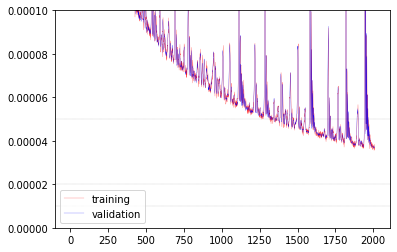

Epoch: 201, loss_train: 0.000037560785, loss_valid: 0.000035781093, best loss: 0.000035781093
Epoch: 202, loss_train: 0.000037708818, loss_valid: 0.000036492736, best loss: 0.000035781093
Epoch: 203, loss_train: 0.000036209218, loss_valid: 0.000035605954, best loss: 0.000035421523
Epoch: 204, loss_train: 0.000042390468, loss_valid: 0.000041649964, best loss: 0.000035421523
Epoch: 205, loss_train: 0.000039572016, loss_valid: 0.000039142349, best loss: 0.000035421523
Epoch: 206, loss_train: 0.000036913741, loss_valid: 0.000036228157, best loss: 0.000034929610
Epoch: 207, loss_train: 0.000082636332, loss_valid: 0.000085403735, best loss: 0.000034929610
Epoch: 208, loss_train: 0.000041227810, loss_valid: 0.000050995790, best loss: 0.000034929610
Epoch: 209, loss_train: 0.000038725382, loss_valid: 0.000040184332, best loss: 0.000034469082
Epoch: 210, loss_train: 0.000036332523, loss_valid: 0.000035803161, best loss: 0.000034469082
Epoch L1 regularization 0.00000019


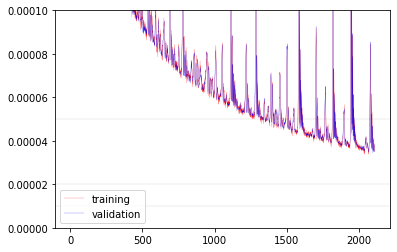

Epoch: 211, loss_train: 0.000039446189, loss_valid: 0.000037327067, best loss: 0.000034469082
Epoch: 212, loss_train: 0.000038769209, loss_valid: 0.000038236936, best loss: 0.000034307173
Epoch: 213, loss_train: 0.000038226866, loss_valid: 0.000034708206, best loss: 0.000034307173
Epoch: 214, loss_train: 0.000047736659, loss_valid: 0.000056431742, best loss: 0.000034307173
Epoch: 215, loss_train: 0.000059253522, loss_valid: 0.000042897758, best loss: 0.000034307173
Epoch: 216, loss_train: 0.000039896098, loss_valid: 0.000035147568, best loss: 0.000034307173
Epoch: 217, loss_train: 0.000037776543, loss_valid: 0.000034626213, best loss: 0.000034206922
Epoch: 218, loss_train: 0.000035760131, loss_valid: 0.000034465887, best loss: 0.000033781489
Epoch: 219, loss_train: 0.000033954646, loss_valid: 0.000033077067, best loss: 0.000033077067
Epoch: 220, loss_train: 0.000066503788, loss_valid: 0.000075657110, best loss: 0.000033077067
Epoch L1 regularization 0.00000019


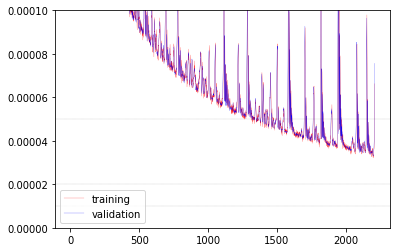

Epoch: 221, loss_train: 0.000036506870, loss_valid: 0.000038392562, best loss: 0.000033077067
Epoch: 222, loss_train: 0.000035067816, loss_valid: 0.000035796496, best loss: 0.000033077067
Epoch: 223, loss_train: 0.000035226647, loss_valid: 0.000032457807, best loss: 0.000032457807
Epoch: 224, loss_train: 0.000034956589, loss_valid: 0.000034957011, best loss: 0.000032363754
Epoch: 225, loss_train: 0.000035530466, loss_valid: 0.000033442302, best loss: 0.000032363754
Epoch: 226, loss_train: 0.000053908698, loss_valid: 0.000059701288, best loss: 0.000032287946
Epoch: 227, loss_train: 0.000044973192, loss_valid: 0.000033855962, best loss: 0.000032287946
Epoch: 228, loss_train: 0.000035930098, loss_valid: 0.000032860014, best loss: 0.000032287946
Epoch: 229, loss_train: 0.000036447393, loss_valid: 0.000034067867, best loss: 0.000032287946
Epoch: 230, loss_train: 0.000033576489, loss_valid: 0.000032146061, best loss: 0.000032146061
Epoch L1 regularization 0.00000019


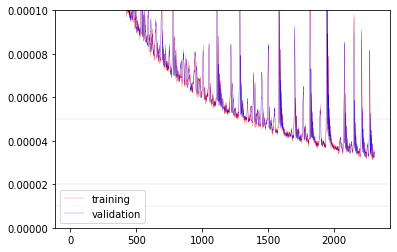

Epoch: 231, loss_train: 0.000048171005, loss_valid: 0.000051516185, best loss: 0.000031301988
Epoch: 232, loss_train: 0.000041590898, loss_valid: 0.000038092810, best loss: 0.000031301988
Epoch: 233, loss_train: 0.000032828328, loss_valid: 0.000031492393, best loss: 0.000031301988
Epoch: 234, loss_train: 0.000032253276, loss_valid: 0.000031166044, best loss: 0.000030674950
Epoch: 235, loss_train: 0.000048664398, loss_valid: 0.000073352923, best loss: 0.000030674950
Epoch: 236, loss_train: 0.000061404426, loss_valid: 0.000134330810, best loss: 0.000030674950
Epoch: 237, loss_train: 0.000069123693, loss_valid: 0.000040058207, best loss: 0.000030674950
Epoch: 238, loss_train: 0.000037967005, loss_valid: 0.000044967313, best loss: 0.000030674950
Epoch: 239, loss_train: 0.000039776347, loss_valid: 0.000035585093, best loss: 0.000030674950
Epoch: 240, loss_train: 0.000035867215, loss_valid: 0.000033452907, best loss: 0.000030674950
Epoch L1 regularization 0.00000019


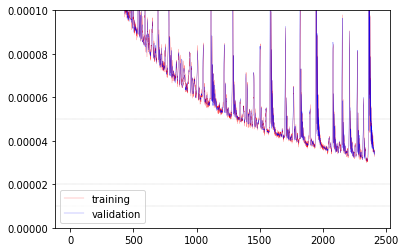

Epoch: 241, loss_train: 0.000034644825, loss_valid: 0.000032952263, best loss: 0.000030674950
Epoch: 242, loss_train: 0.000033652490, loss_valid: 0.000031828775, best loss: 0.000030674950
Epoch: 243, loss_train: 0.000033566146, loss_valid: 0.000031808773, best loss: 0.000030674950
Epoch: 244, loss_train: 0.000032896354, loss_valid: 0.000031372507, best loss: 0.000030674950
Epoch: 245, loss_train: 0.000031682779, loss_valid: 0.000031016418, best loss: 0.000030646443
Epoch: 246, loss_train: 0.000032354586, loss_valid: 0.000031033505, best loss: 0.000030646443
Epoch: 247, loss_train: 0.000031899002, loss_valid: 0.000030346402, best loss: 0.000030346402
Epoch: 248, loss_train: 0.000031939973, loss_valid: 0.000030359644, best loss: 0.000030346402
Epoch: 249, loss_train: 0.000033114429, loss_valid: 0.000031633375, best loss: 0.000030082381
Epoch: 250, loss_train: 0.000038726932, loss_valid: 0.000039004437, best loss: 0.000030082381
Epoch L1 regularization 0.00000019


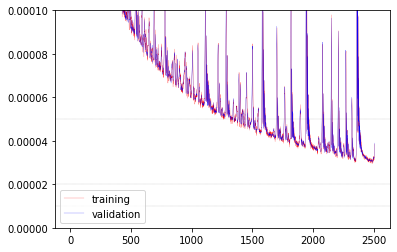

Epoch: 251, loss_train: 0.000033881664, loss_valid: 0.000036559308, best loss: 0.000030082381
Epoch: 252, loss_train: 0.000039803796, loss_valid: 0.000036142432, best loss: 0.000030077519
Epoch: 253, loss_train: 0.000034679026, loss_valid: 0.000032319887, best loss: 0.000030077519
Epoch: 254, loss_train: 0.000035078730, loss_valid: 0.000034807155, best loss: 0.000029405819
Epoch: 255, loss_train: 0.000033940105, loss_valid: 0.000029107390, best loss: 0.000029107390
Epoch: 256, loss_train: 0.000036499579, loss_valid: 0.000033671986, best loss: 0.000029107390
Epoch: 257, loss_train: 0.000035308127, loss_valid: 0.000034784061, best loss: 0.000028654977
Epoch: 258, loss_train: 0.000029730909, loss_valid: 0.000028263368, best loss: 0.000028263368
Epoch: 259, loss_train: 0.000037300790, loss_valid: 0.000050544622, best loss: 0.000028197652
Epoch: 260, loss_train: 0.000039680515, loss_valid: 0.000077556339, best loss: 0.000028197652
Epoch L1 regularization 0.00000019


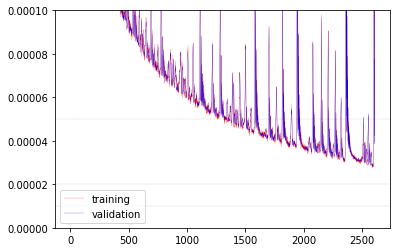

Epoch: 261, loss_train: 0.000049106362, loss_valid: 0.000052534633, best loss: 0.000028197652
Epoch: 262, loss_train: 0.000037969086, loss_valid: 0.000032868811, best loss: 0.000028197652
Epoch: 263, loss_train: 0.000033298340, loss_valid: 0.000034542820, best loss: 0.000028197652
Epoch: 264, loss_train: 0.000032119198, loss_valid: 0.000031298150, best loss: 0.000028197652
Epoch: 265, loss_train: 0.000031727424, loss_valid: 0.000030686617, best loss: 0.000028197652
Epoch: 266, loss_train: 0.000030616102, loss_valid: 0.000029866273, best loss: 0.000028197652
Epoch: 267, loss_train: 0.000029962621, loss_valid: 0.000029145684, best loss: 0.000028197652
Epoch: 268, loss_train: 0.000029613535, loss_valid: 0.000028398226, best loss: 0.000028197652
Epoch: 269, loss_train: 0.000030075731, loss_valid: 0.000028039502, best loss: 0.000027730050
Epoch: 270, loss_train: 0.000029053015, loss_valid: 0.000027946631, best loss: 0.000027416634
Epoch L1 regularization 0.00000019


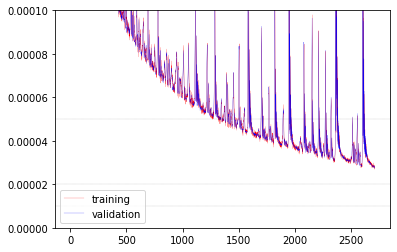

Epoch: 271, loss_train: 0.000028520968, loss_valid: 0.000027341830, best loss: 0.000026932899
Epoch: 272, loss_train: 0.000090993955, loss_valid: 0.000152656445, best loss: 0.000026932899
Epoch: 273, loss_train: 0.000063143721, loss_valid: 0.000035921646, best loss: 0.000026932899
Epoch: 274, loss_train: 0.000042447016, loss_valid: 0.000031161082, best loss: 0.000026932899
Epoch: 275, loss_train: 0.000033585264, loss_valid: 0.000028937817, best loss: 0.000026932899
Epoch: 276, loss_train: 0.000029434432, loss_valid: 0.000028704948, best loss: 0.000026932899
Epoch: 277, loss_train: 0.000029040426, loss_valid: 0.000027543983, best loss: 0.000026932899
Epoch: 278, loss_train: 0.000028612913, loss_valid: 0.000027116910, best loss: 0.000026932899
Epoch: 279, loss_train: 0.000038164486, loss_valid: 0.000038539802, best loss: 0.000026594773
Epoch: 280, loss_train: 0.000037449361, loss_valid: 0.000034279350, best loss: 0.000026594773
Epoch L1 regularization 0.00000019


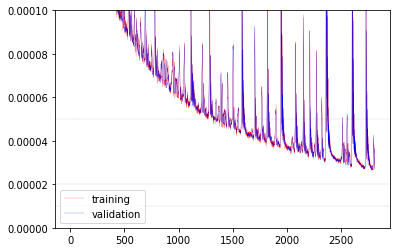

Epoch: 281, loss_train: 0.000034588054, loss_valid: 0.000030973159, best loss: 0.000026594773
Epoch: 282, loss_train: 0.000027194585, loss_valid: 0.000026258054, best loss: 0.000025256086
Epoch: 283, loss_train: 0.000042013493, loss_valid: 0.000071583898, best loss: 0.000025256086
Epoch: 284, loss_train: 0.000063410080, loss_valid: 0.000087153450, best loss: 0.000025256086
Epoch: 285, loss_train: 0.000050237784, loss_valid: 0.000037019250, best loss: 0.000025256086
Epoch: 286, loss_train: 0.000033031745, loss_valid: 0.000029580289, best loss: 0.000025256086
Epoch: 287, loss_train: 0.000029932296, loss_valid: 0.000027824524, best loss: 0.000025256086
Epoch: 288, loss_train: 0.000028939143, loss_valid: 0.000026855545, best loss: 0.000025256086
Epoch: 289, loss_train: 0.000027134516, loss_valid: 0.000027225629, best loss: 0.000025256086
Epoch: 290, loss_train: 0.000027036054, loss_valid: 0.000026306816, best loss: 0.000025256086
Epoch L1 regularization 0.00000019


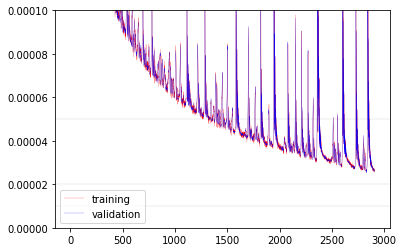

Epoch: 291, loss_train: 0.000028632780, loss_valid: 0.000027917707, best loss: 0.000025256086
Epoch: 292, loss_train: 0.000055885888, loss_valid: 0.000041023210, best loss: 0.000025256086
Epoch: 293, loss_train: 0.000033782875, loss_valid: 0.000029699822, best loss: 0.000025256086
Epoch: 294, loss_train: 0.000026550970, loss_valid: 0.000027943343, best loss: 0.000024576544
Epoch: 295, loss_train: 0.000026709011, loss_valid: 0.000024968318, best loss: 0.000024576544
Epoch: 296, loss_train: 0.000048146412, loss_valid: 0.000068273213, best loss: 0.000024576544
Epoch: 297, loss_train: 0.000059219903, loss_valid: 0.000058694186, best loss: 0.000024576544
Epoch: 298, loss_train: 0.000041216332, loss_valid: 0.000036175410, best loss: 0.000024576544
Epoch: 299, loss_train: 0.000034026340, loss_valid: 0.000028218168, best loss: 0.000024576544
Epoch: 300, loss_train: 0.000026801987, loss_valid: 0.000026867932, best loss: 0.000024576544
Epoch L1 regularization 0.00000019


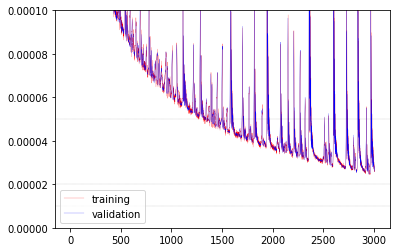

In [6]:
#hidden size is bigger, the accuracy is higher, but higher computation
#if the learning rate is too big, then loss may be stuck at a certain 
#and cannot go down. So, if the loss goes down to a certain value and
#then cannot decrease, just change a smaller learning rate.

num_epochs    = 301
learning_rate = 0.001
L1_lambda     = 0.00000000001

input_size  = trainX.size(2)
output_size = trainY.size(2)
input_seq_size=trainX.size(1)
output_seq_size= trainY.size(1)
embedding_dims = 128#128
fc_size = 64#64

model = TRANSFORMER(input_size, output_size, embedding_dims,fc_size,input_seq_size,output_seq_size) 
model.to(device)  #CUDA

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

best_loss = 99999999999999.99
best_epoch = 0
Loss = [] 
Loss_v = []
t_len = int(trainX.size(0)/10)
v_len = int(validX.size(0)/1)
# Train the model
for epoch in range(num_epochs):
    #print('epoch:   ', epoch)
    for j in range(10):
        torch.cuda.empty_cache()
        
        train_X_temp = trainX[j*t_len:j*t_len+t_len] # 0 to test_size
        train_Y_temp = trainY[j*t_len:j*t_len+t_len]
        
        train_X_temp = train_X_temp.to(device)
        train_Y_temp = train_Y_temp.to(device)

        output = model(train_X_temp, train_Y_temp[:,:-1,:])  # [1:]-> 1,2,3,4,5; [:-1]->0,1,2,3,4
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(output, train_Y_temp[:,4,:].reshape(-1,output_size))
        Loss.append(loss.item())

        ## L1 regularization
        L1_reg = torch.tensor(0., requires_grad=True)
        for name, param in model.named_parameters():
            if 'weight' in name:
                L1_reg = L1_reg + torch.norm(param, 1)

        loss += L1_lambda * L1_reg
        loss.backward()
        optimizer.step()
        
        #validation
        loss_v = 0
        for j in range(1):
            validX_temp = validX[j*v_len:j*v_len + v_len] # 0 to test_size
            validY_temp = validY[j*v_len:j*v_len + v_len]
        
            validX_temp = validX_temp.to(device)
            validY_temp = validY_temp.to(device)  
        
            output = model(validX_temp, validY_temp[:,:-1,:])  # [1:]-> 1,2,3,4,5; [:-1]->0,1,2,3,4
            loss_v += criterion(output, validY_temp[:,4,:].reshape(-1,output_size)).item()   # + L1_lambda * L1_reg
        loss_v = loss_v/1
        Loss_v.append(loss_v)
        
        if loss_v < best_loss:
            torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        }, PATH)
            best_loss = loss_v
    
    #if epoch % 10 == 0:
    print("Epoch: %d, loss_train: %1.12f, loss_valid: %1.12f, best loss: %1.12f" % (epoch, loss.item(), loss_v, best_loss))
              
    if epoch % 10 == 0:
        print("Epoch L1 regularization %1.8f" % (L1_lambda * L1_reg))
        plt.plot(Loss,c='r', linewidth=0.2, Label = 'training')
        plt.plot(Loss_v,c='b', linewidth=0.2, Label = 'validation')
        plt.ylim(0, 0.0001)
        plt.axhline(y=0.00005, c='black', linestyle='--', linewidth=0.1)
        plt.axhline(y=0.00002, c='black', linestyle='--', linewidth=0.1)
        plt.axhline(y=0.00001, c='black', linestyle='--', linewidth=0.1)
        plt.legend()
        plt.show()

## Save model

In [9]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH_cur)

## Load model

In [7]:
num_epochs    = 301
learning_rate = 0.001
L1_lambda     = 0.00000000001

input_size  = trainX.size(2)
output_size = trainY.size(2)
input_seq_size=trainX.size(1)
output_seq_size= trainY.size(1)
embedding_dims = 128#128
fc_size = 64#64

model = TRANSFORMER(input_size, output_size, embedding_dims,fc_size,input_seq_size,output_seq_size) 
model.to(device)  #CUDA

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

if device == "cuda:0":
    checkpoint = torch.load(PATH)
else:
    checkpoint = torch.load(PATH, map_location = torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


## Test

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001577


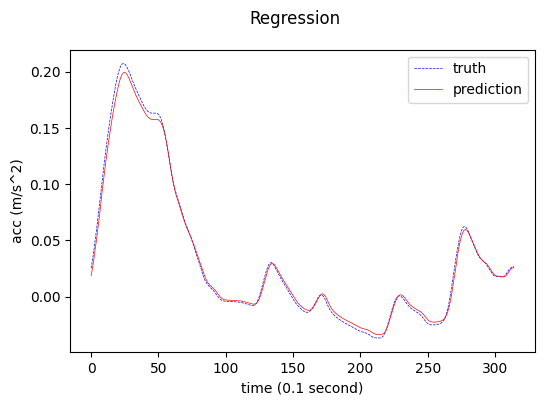

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00003837


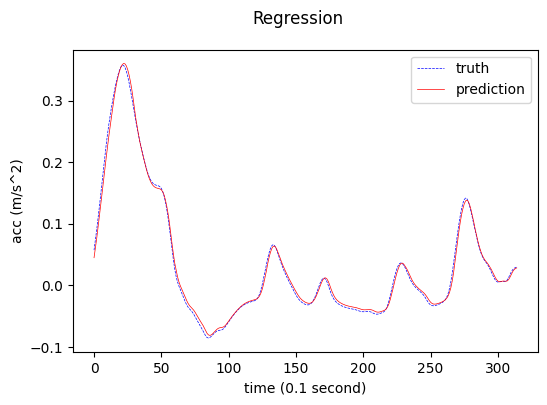

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002371


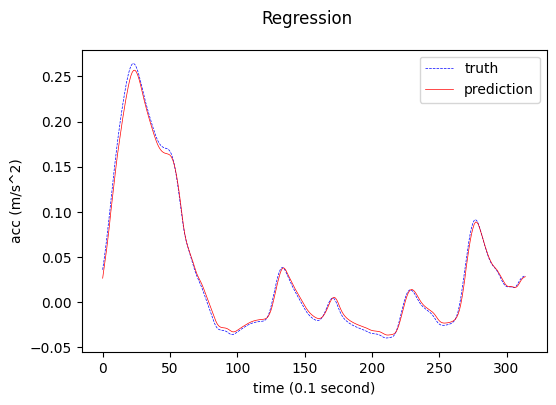

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001424


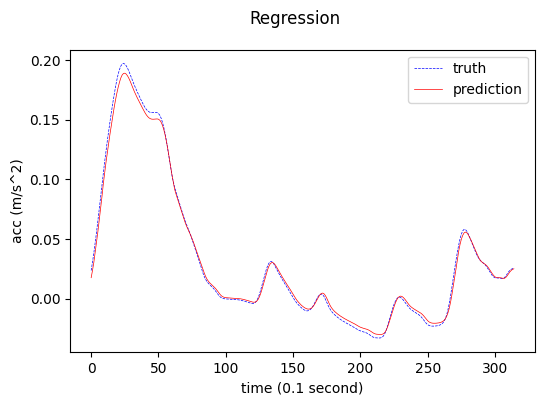

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00003035


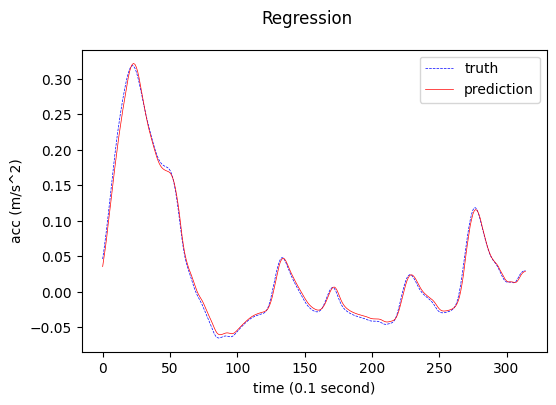

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002195


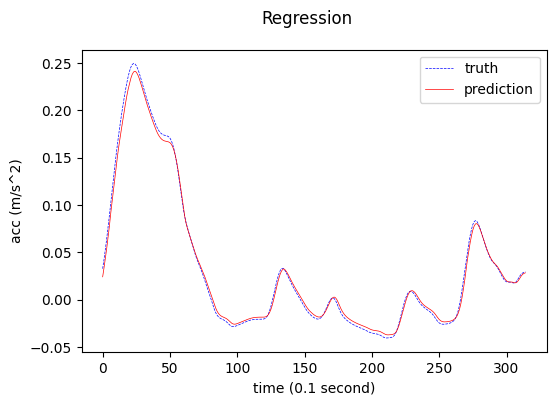

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001829


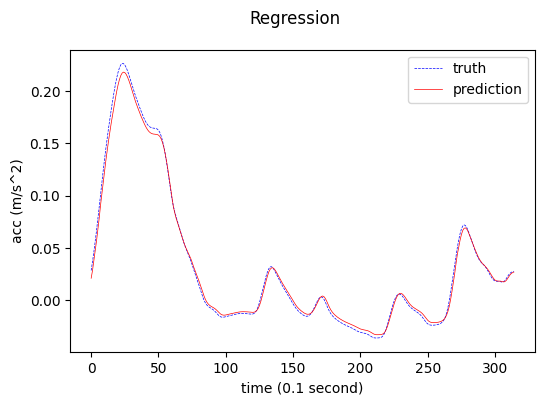

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002790


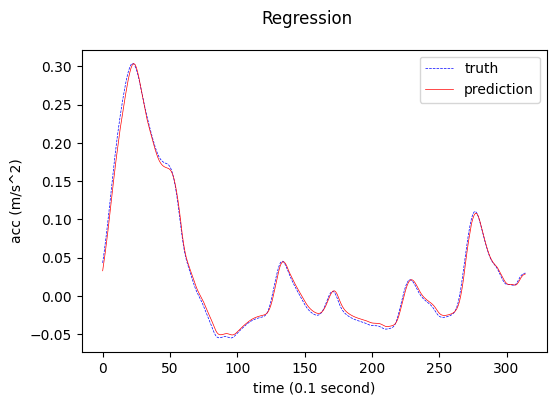

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002123


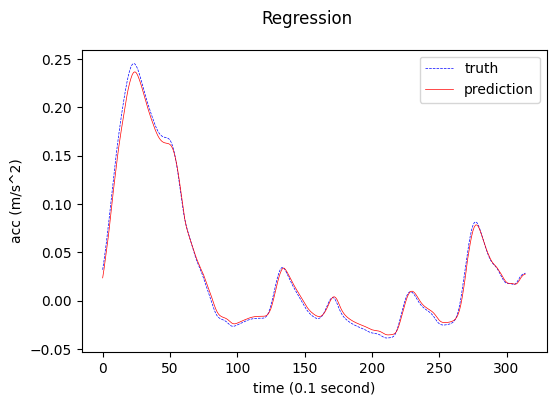

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001699


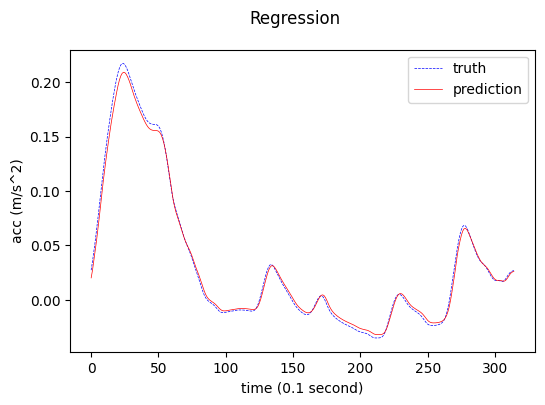

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002756


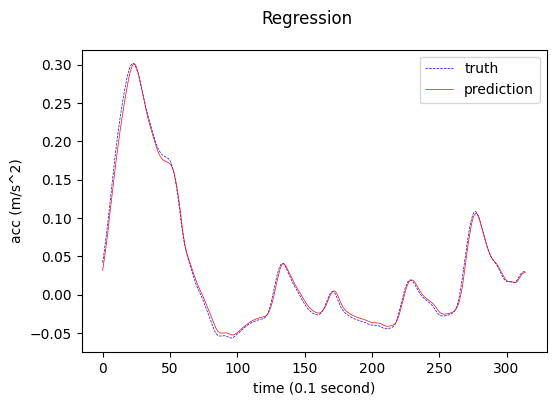

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002568


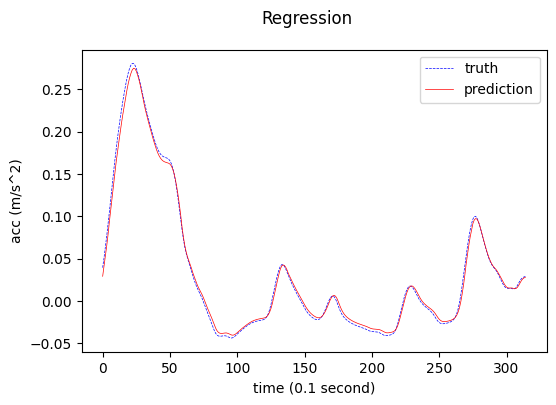

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001721


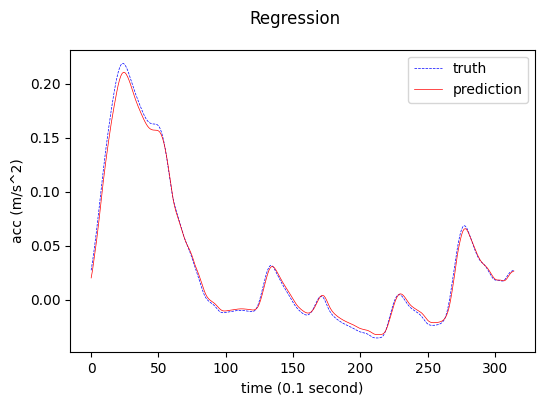

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00003273


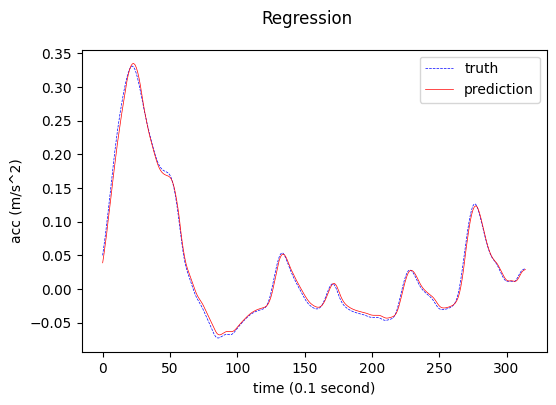

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002279


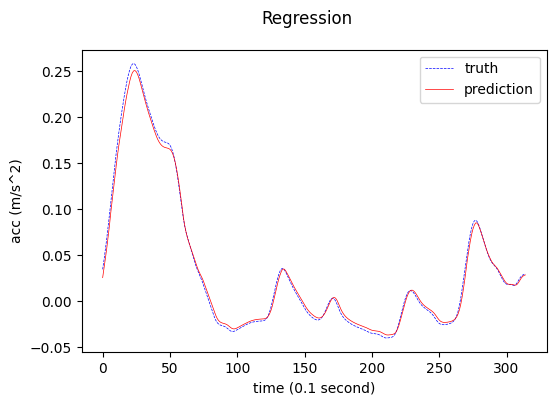

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001783


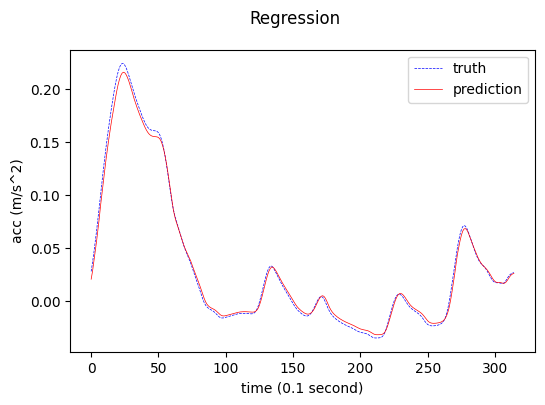

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002766


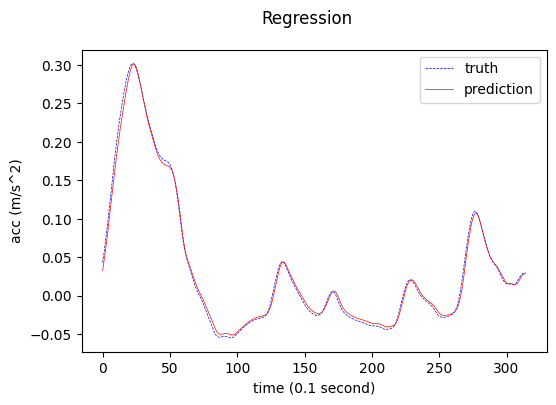

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002216


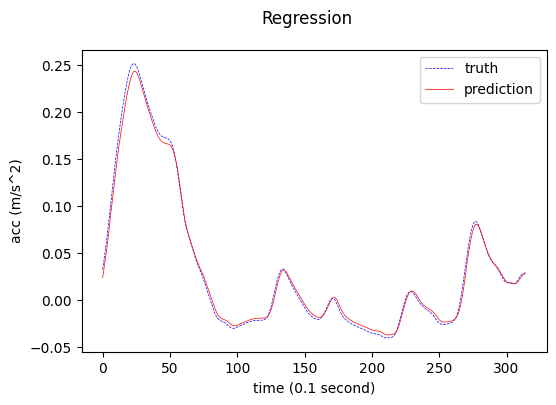

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001721


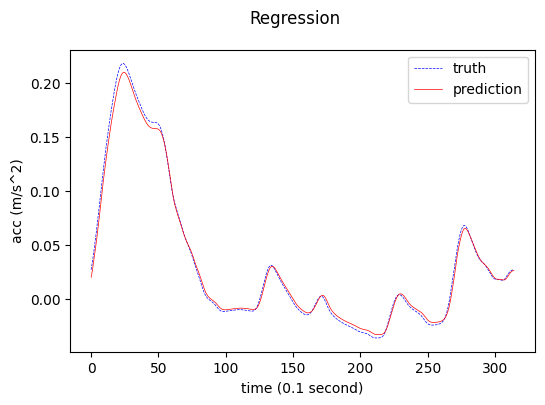

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00004069


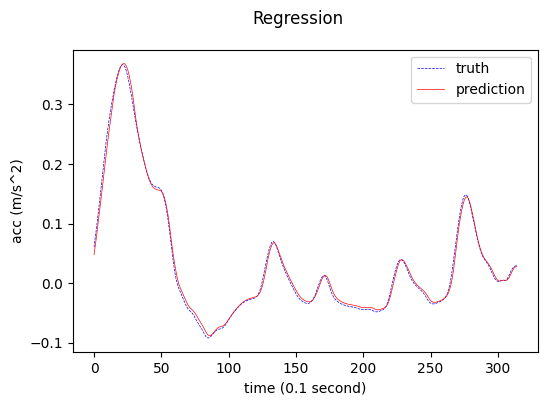

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001963


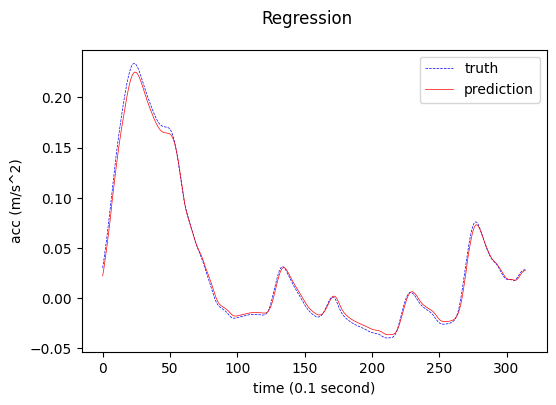

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001334


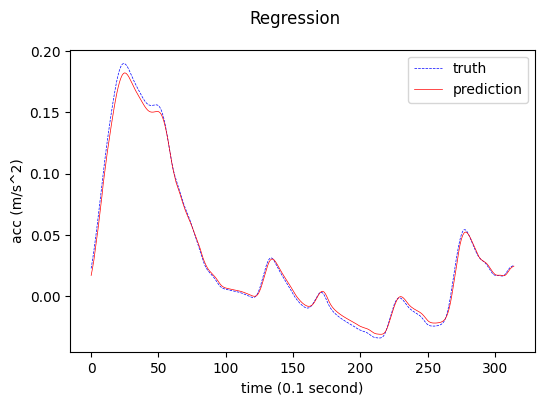

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00003065


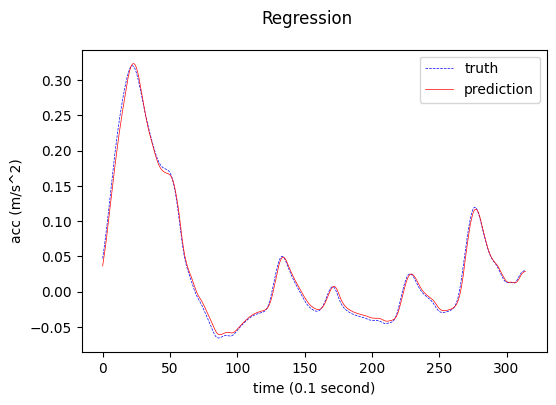

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002411


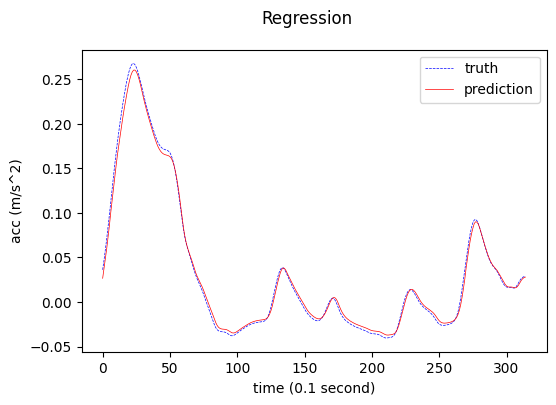

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001675


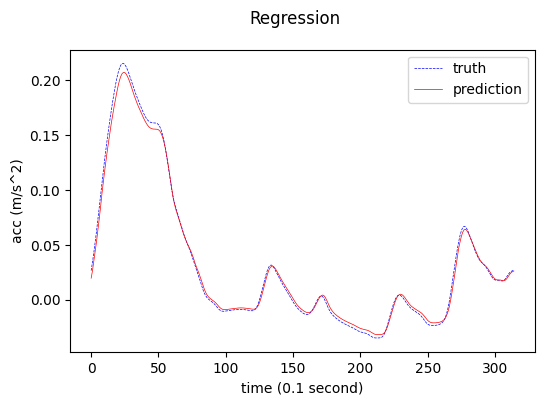

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00003052


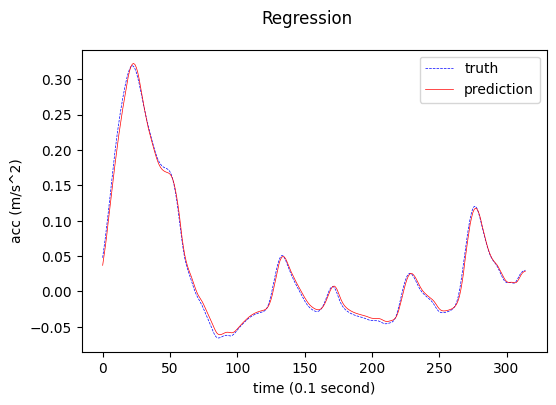

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002183


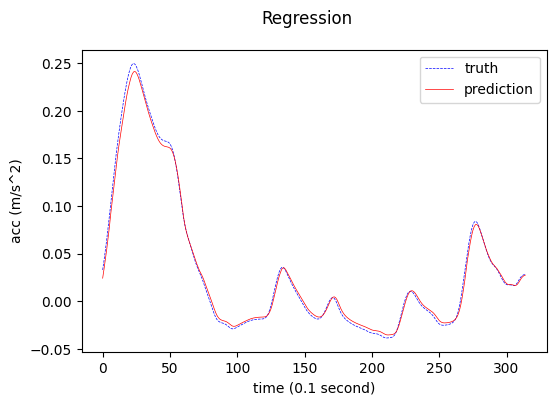

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001709


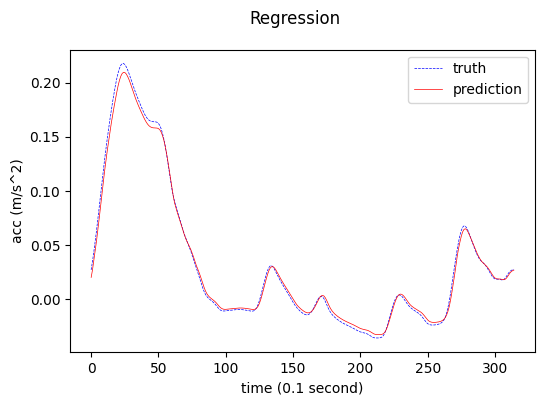

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002850


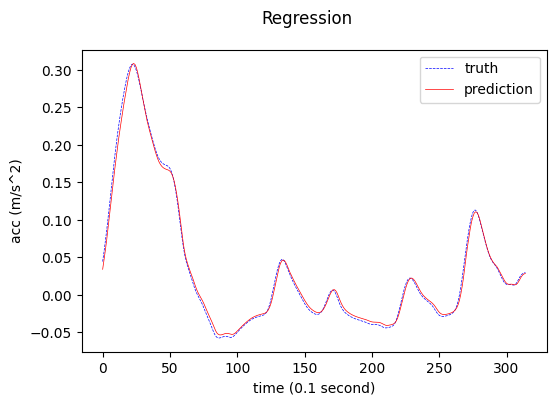

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002288


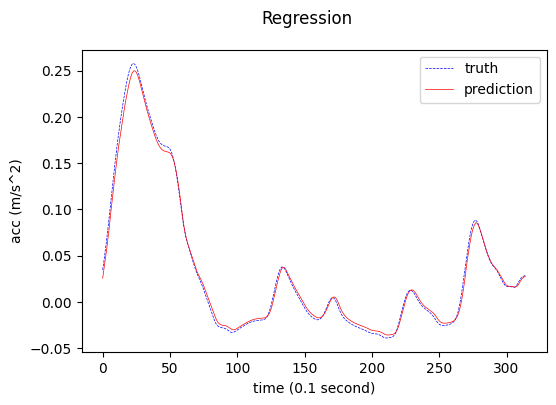

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001807


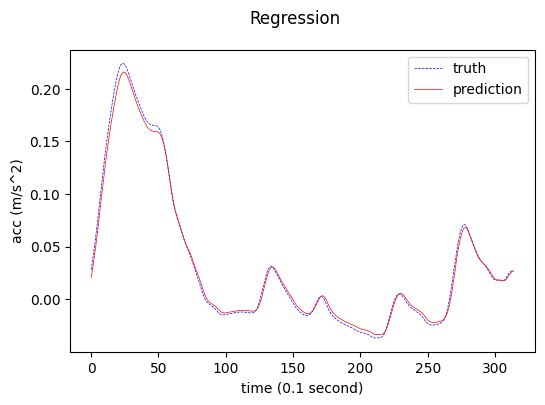

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00003569


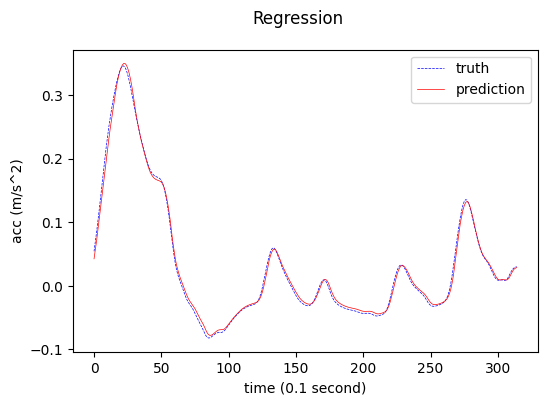

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002210


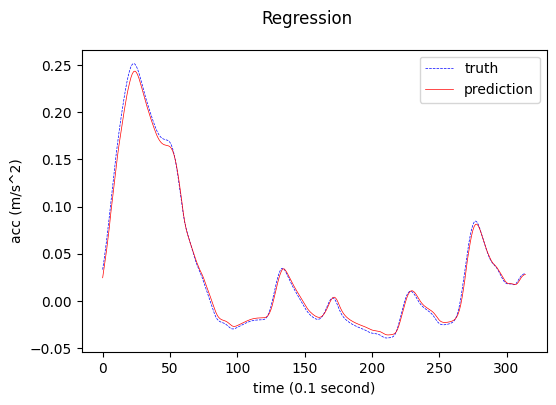

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001640


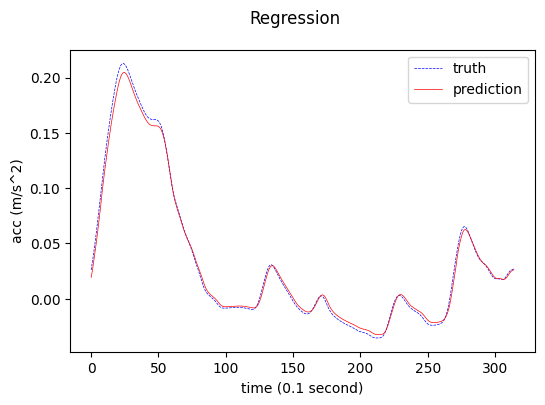

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00003354


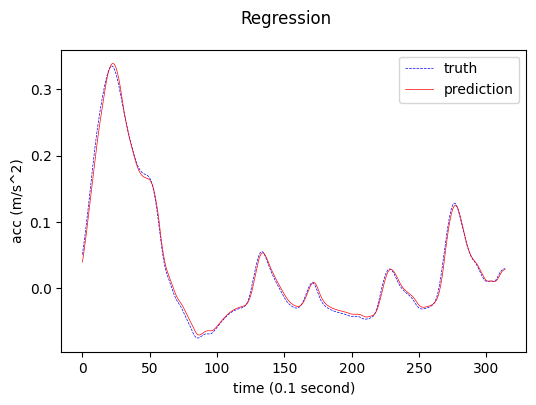

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002335


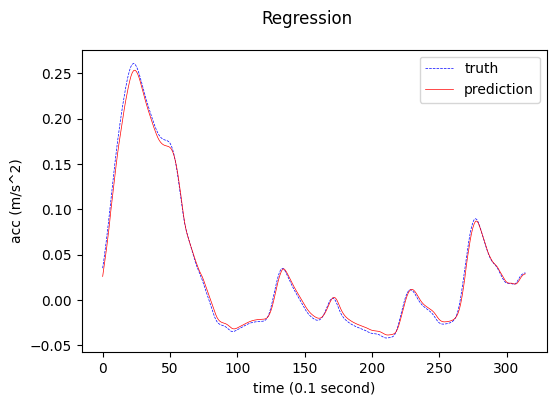

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001716


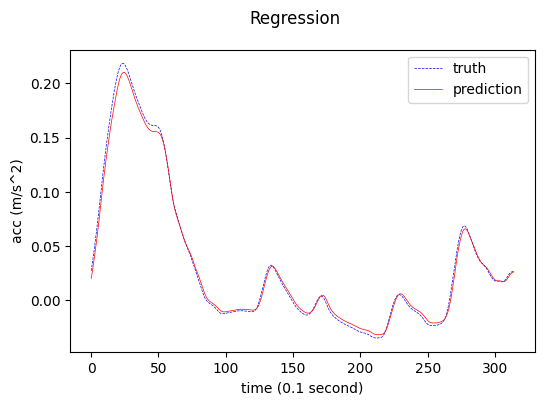

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00003505


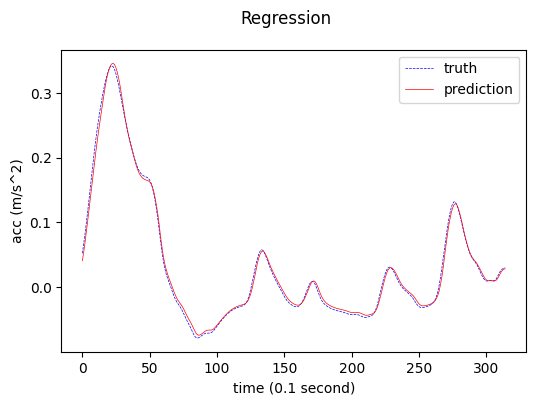

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002715


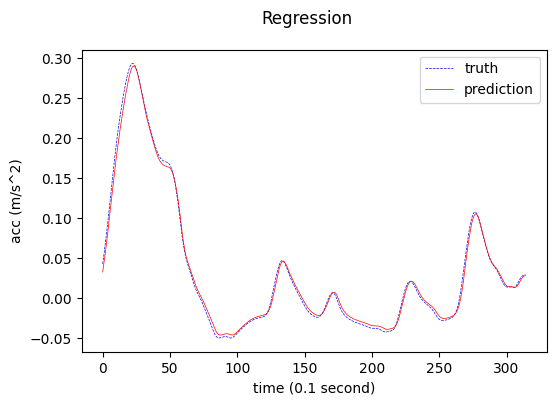

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001937


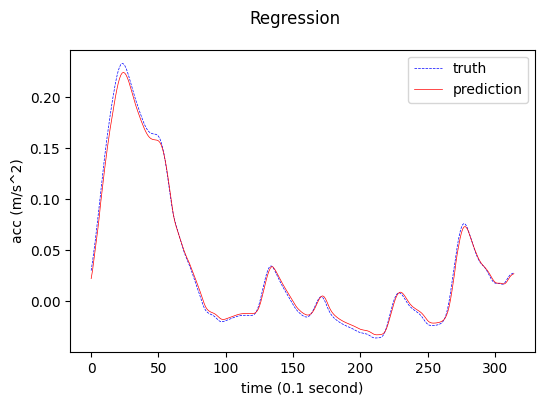

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00003573


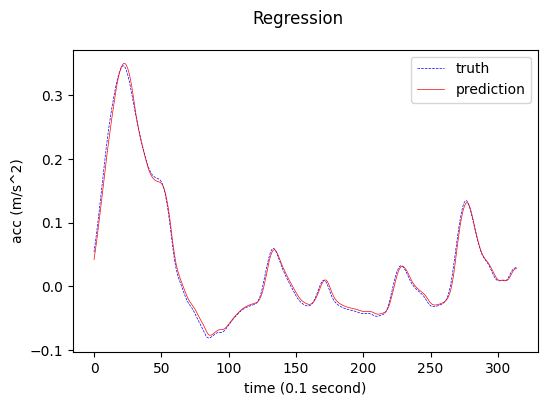

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002528


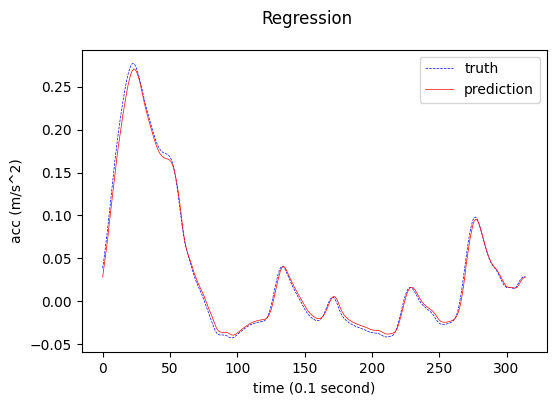

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001925


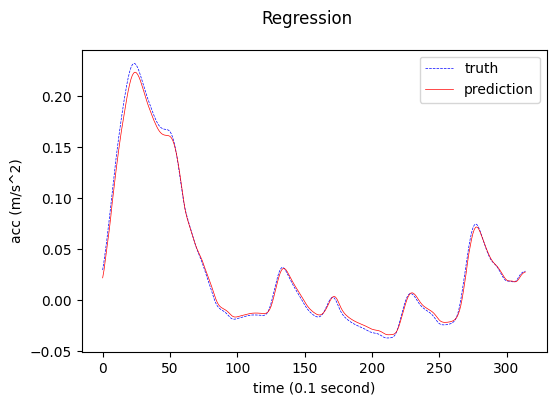

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00003021


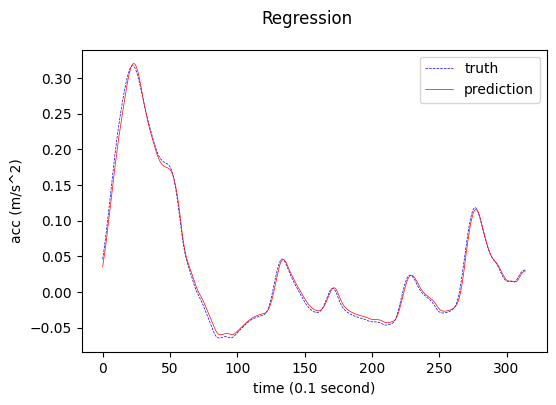

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002488


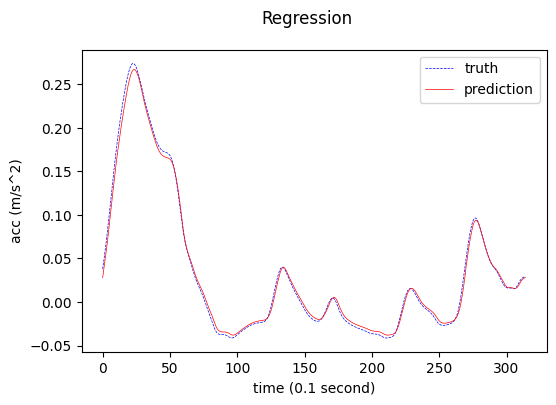

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001731


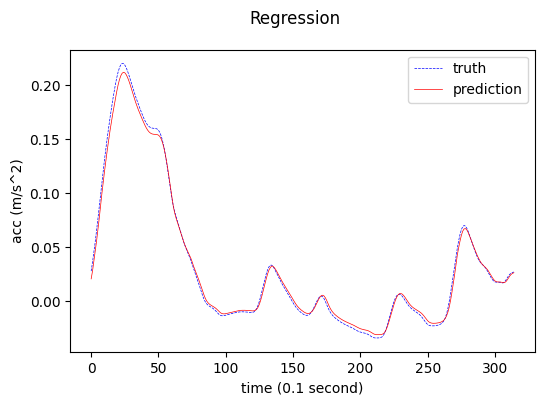

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002743


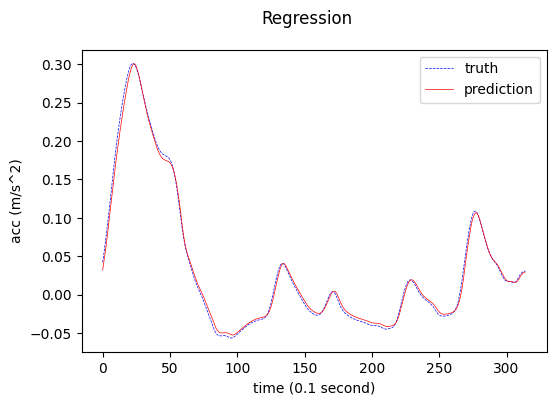

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002000


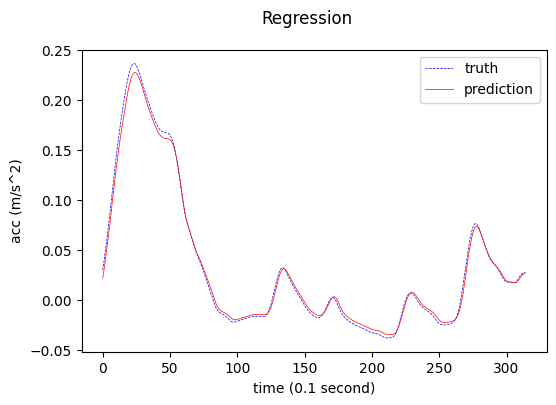

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001689


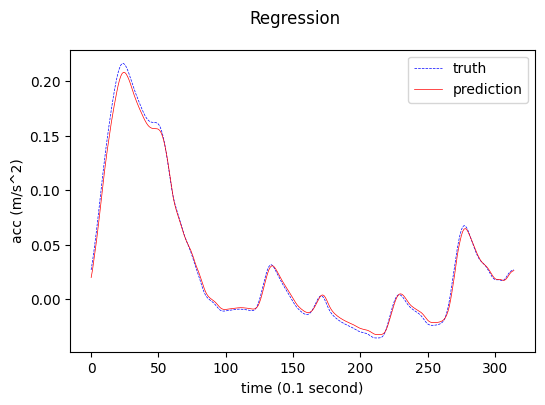

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00003460


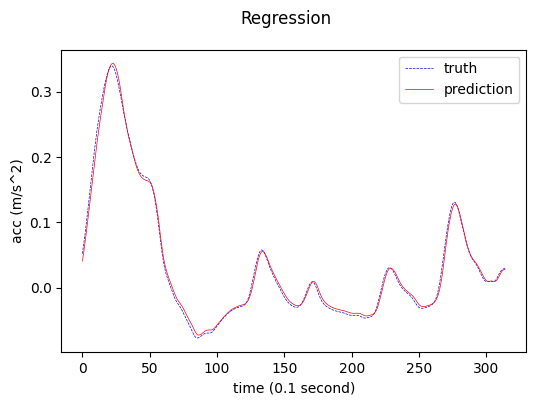

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002301


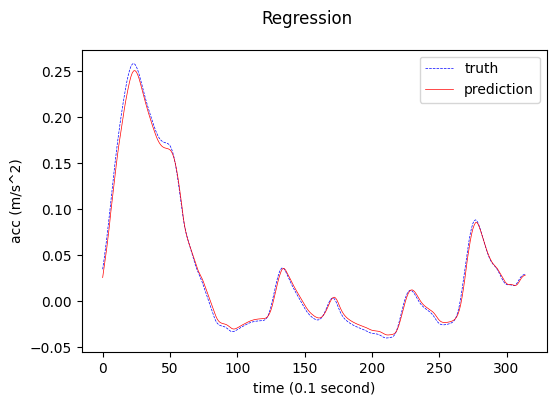

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001633


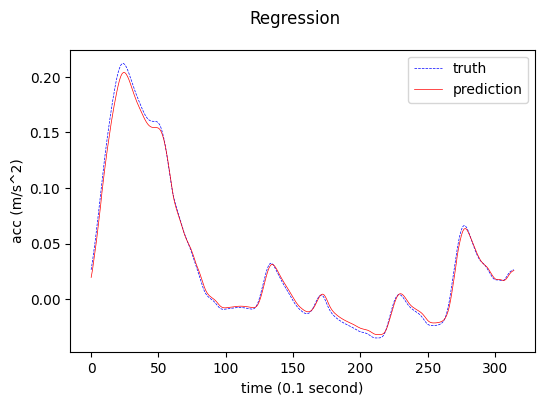

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002962


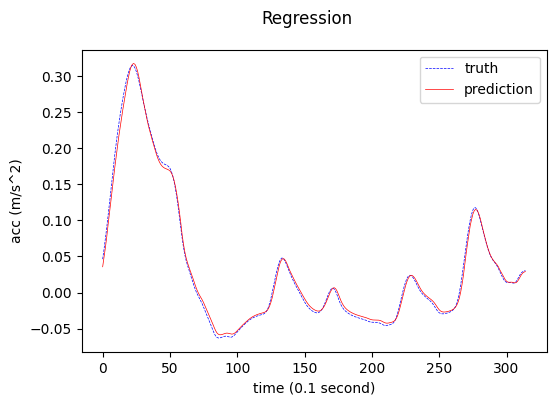

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002445


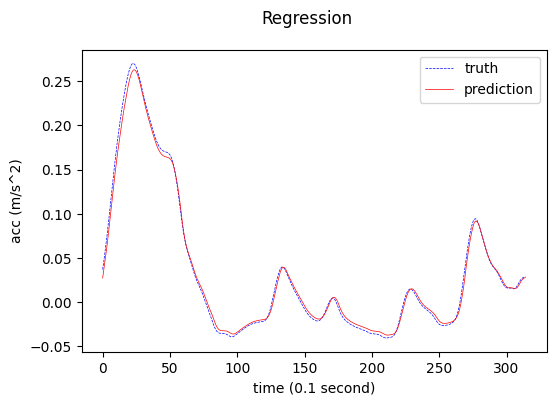

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001827


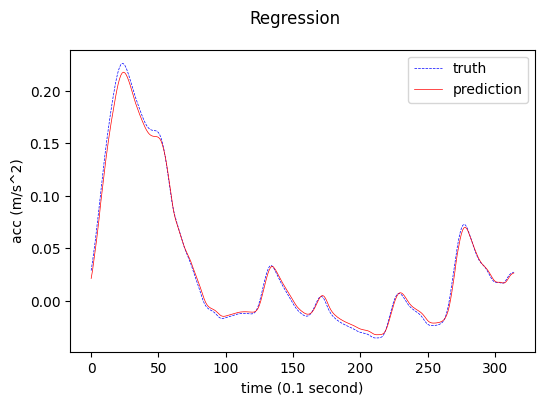

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00003669


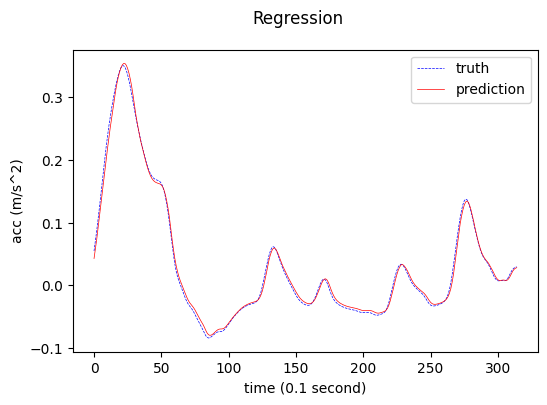

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002211


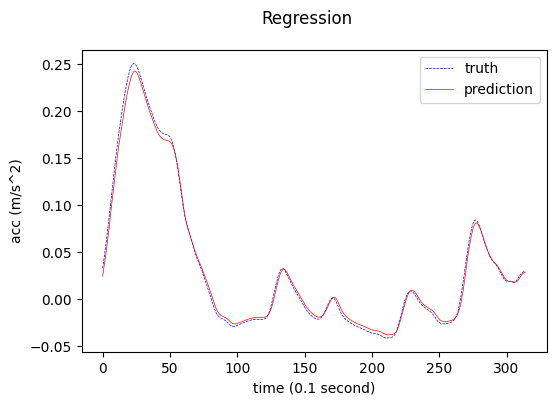

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002323


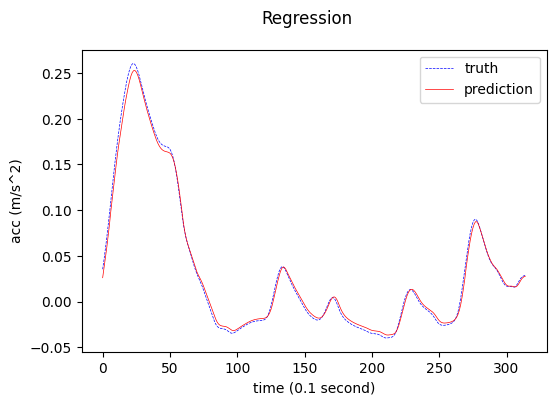

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00003613


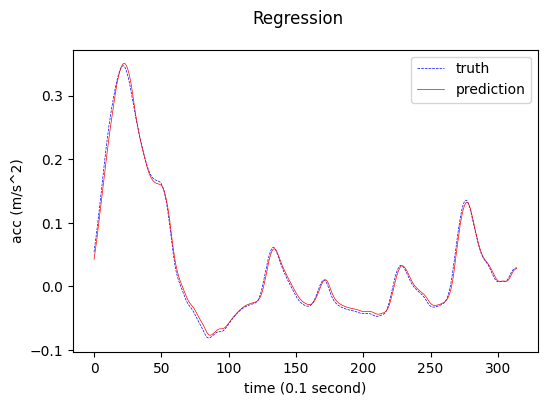

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002358


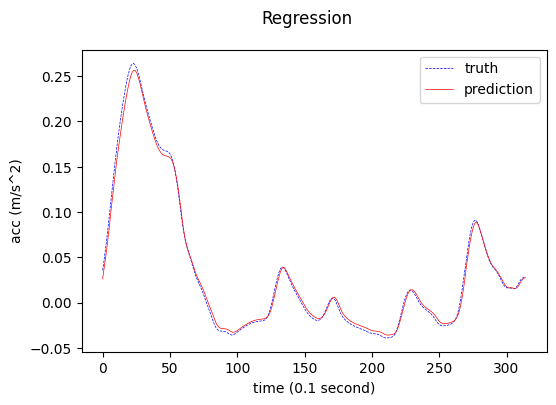

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001427


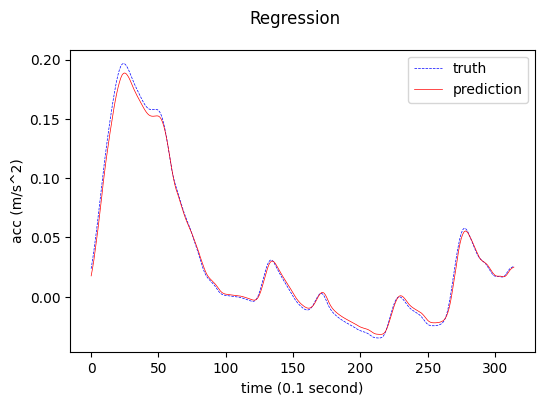

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002792


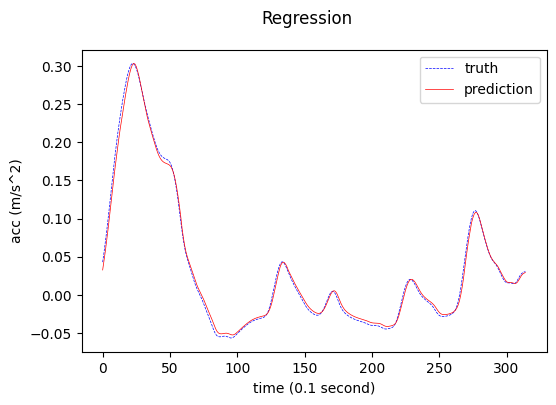

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002134


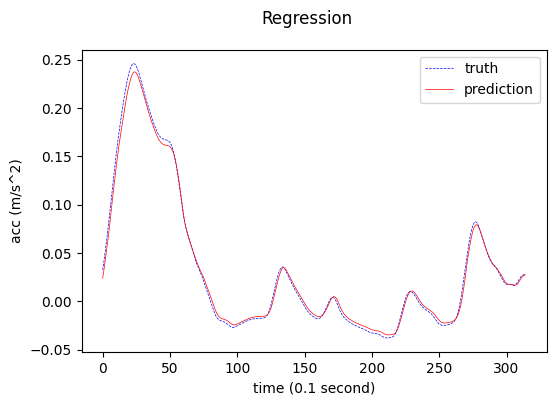

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001870


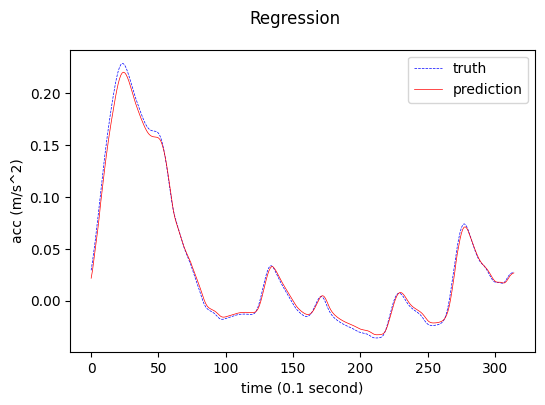

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00003824


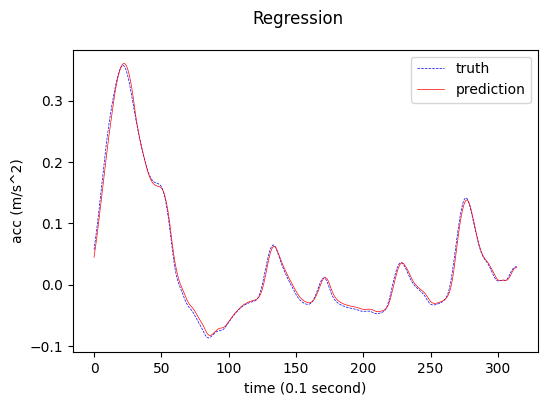

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002129


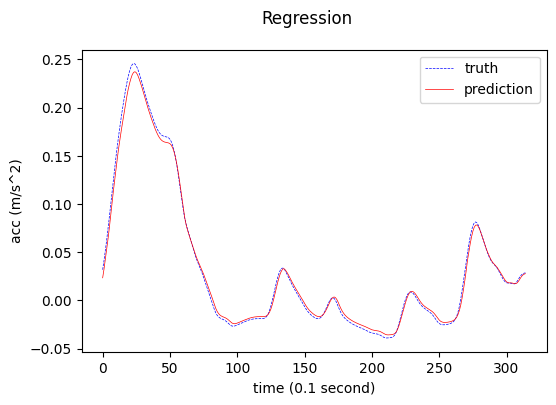

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001823


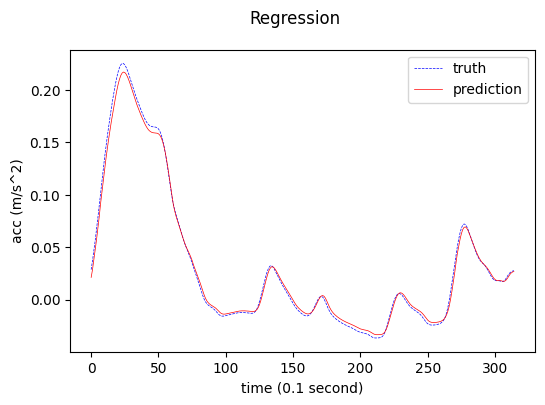

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002798


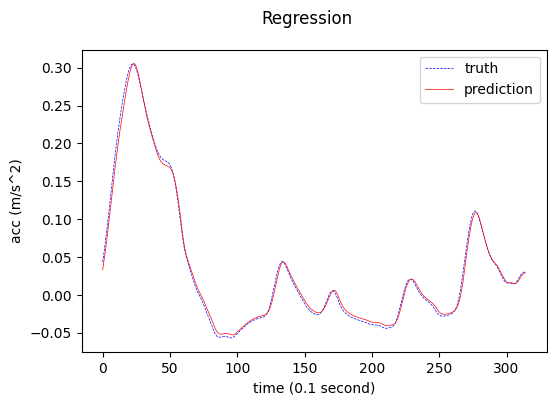

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002205


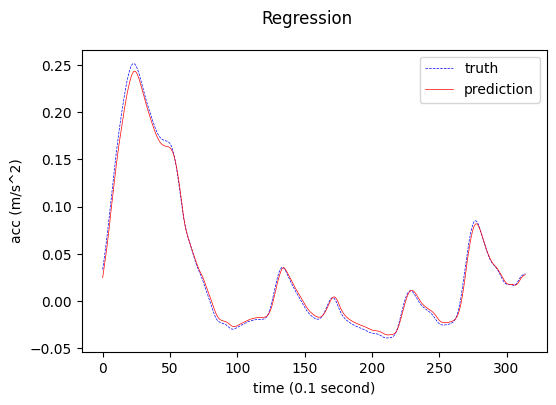

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001587


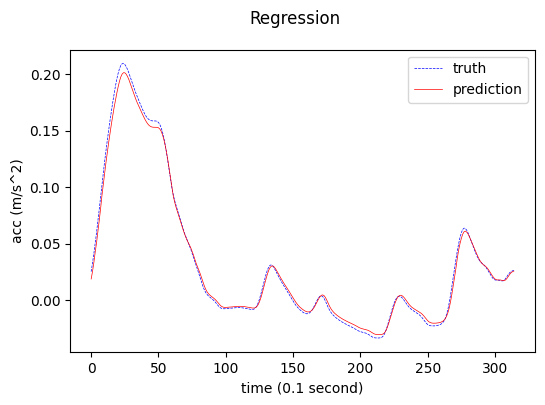

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00006339


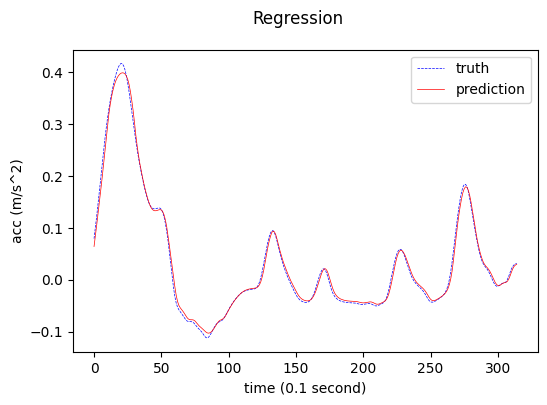

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002376


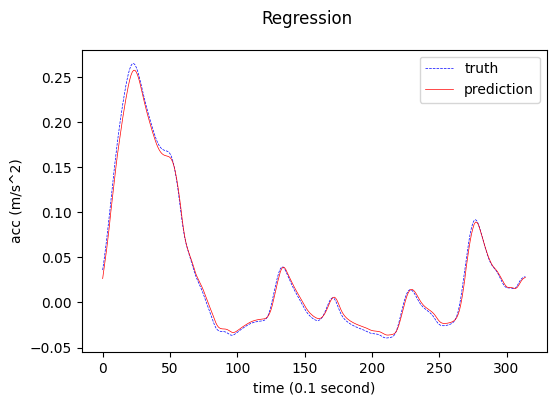

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001798


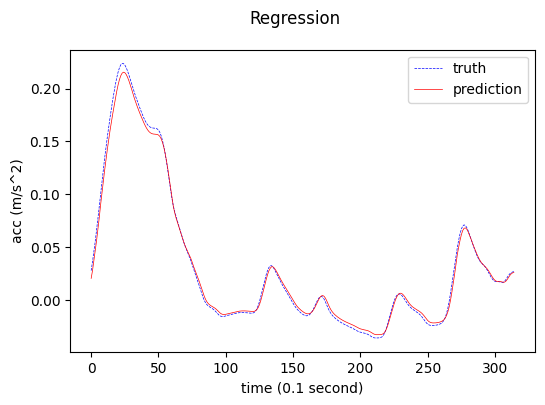

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00003153


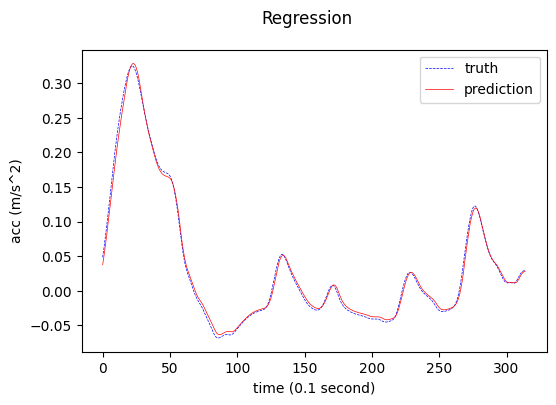

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002704


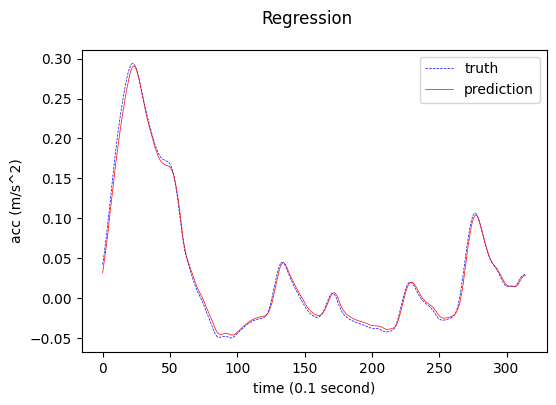

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002073


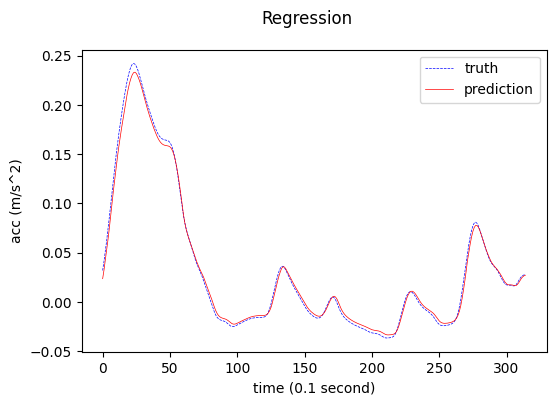

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00003528


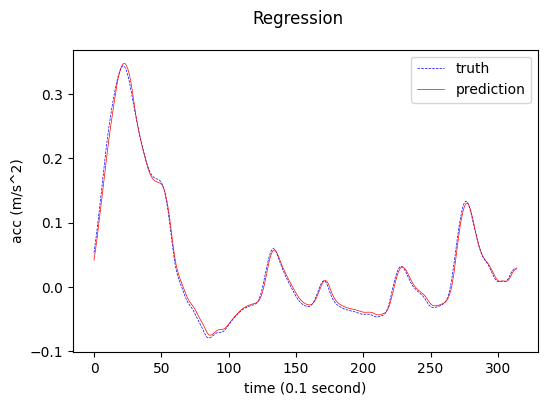

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002353


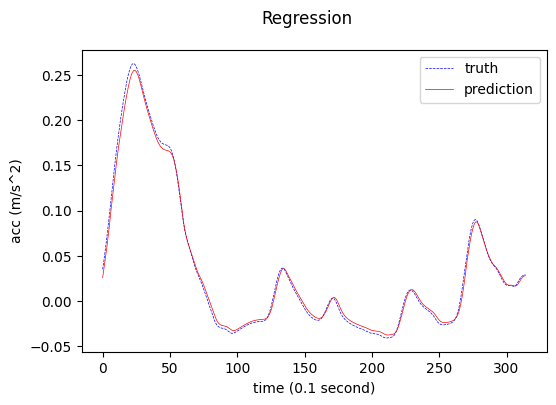

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002048


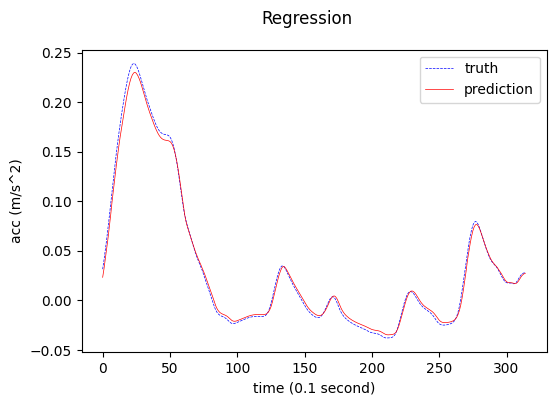

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00003404


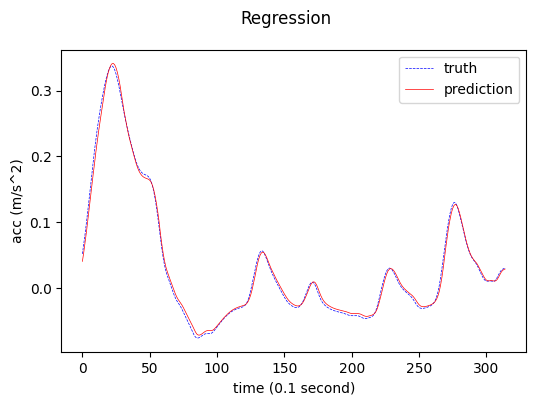

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002166


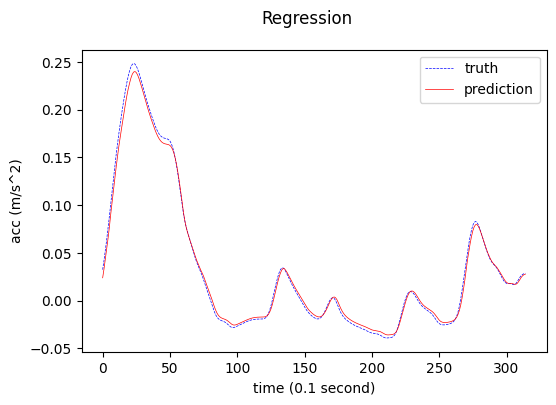

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001590


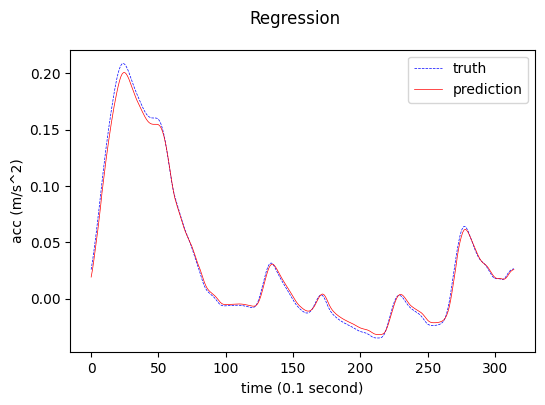

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00003197


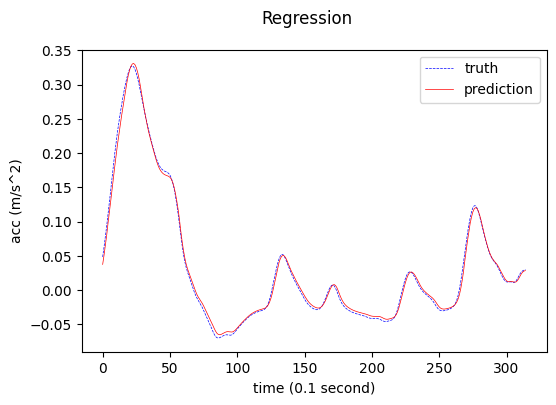

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002414


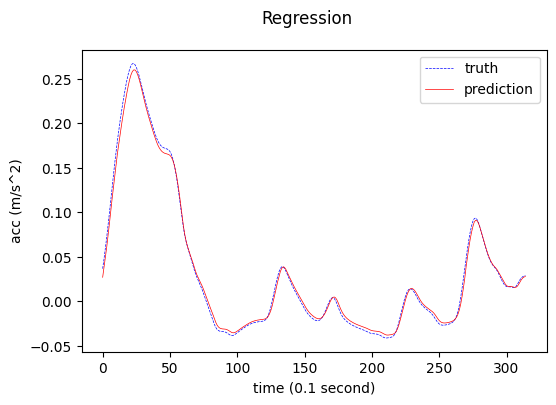

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001760


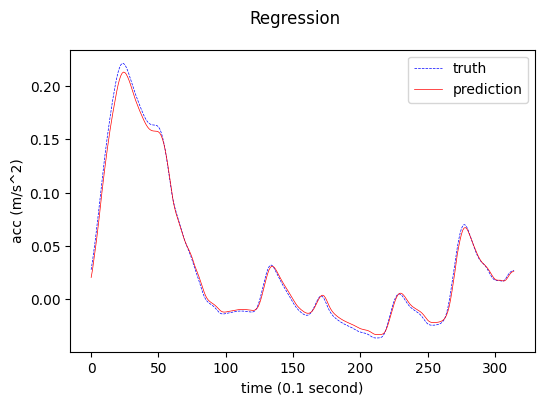

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00003037


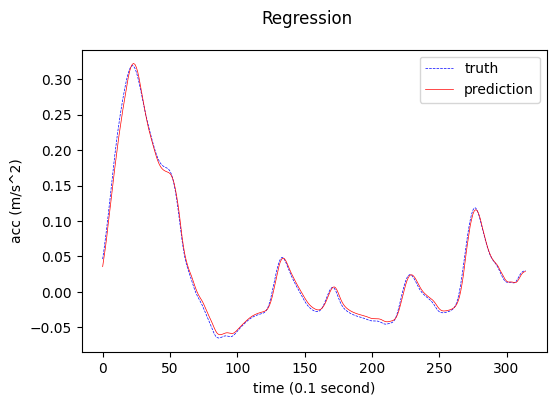

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002471


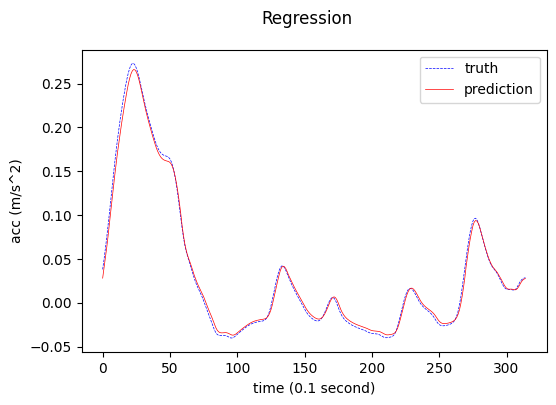

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002122


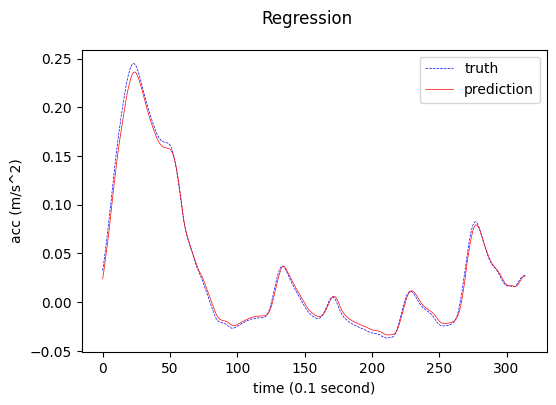

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00003438


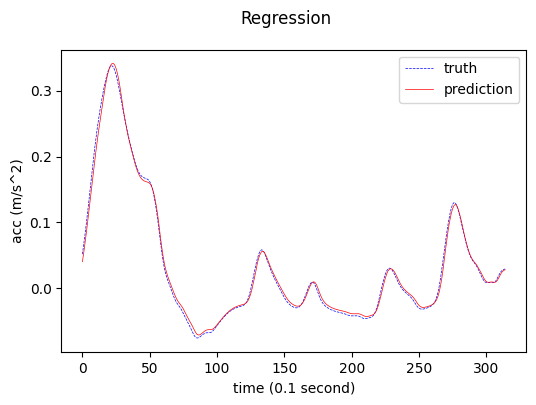

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002278


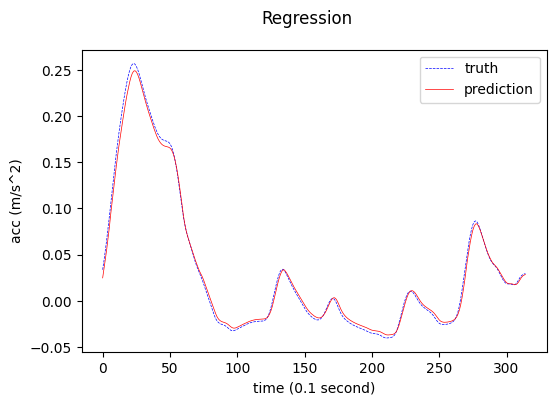

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002106


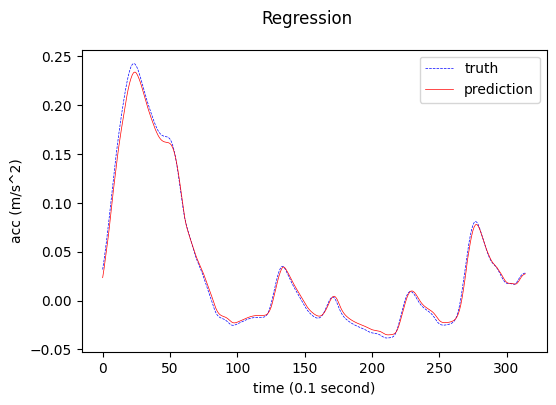

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00003270


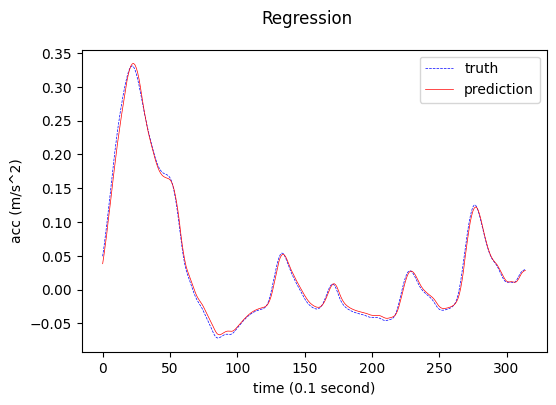

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002393


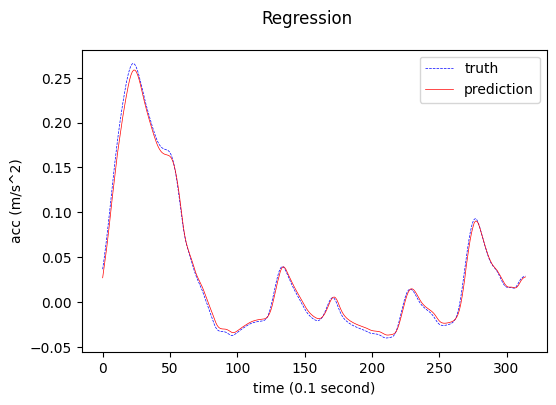

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002184


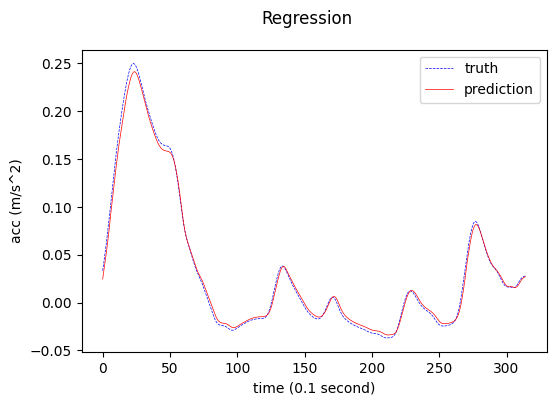

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00003177


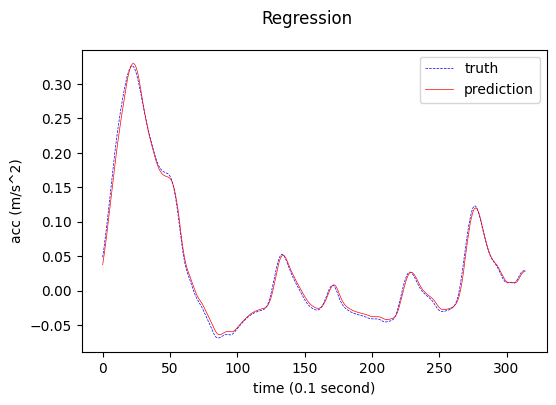

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001754


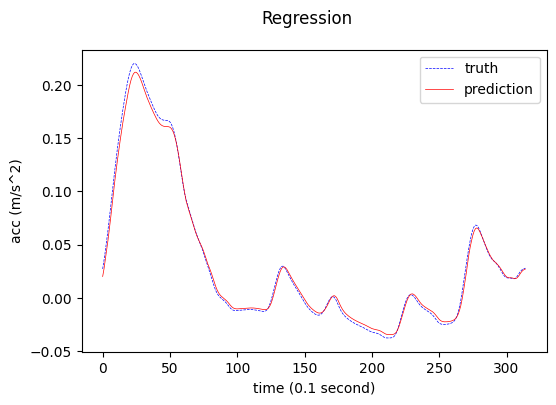

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001897


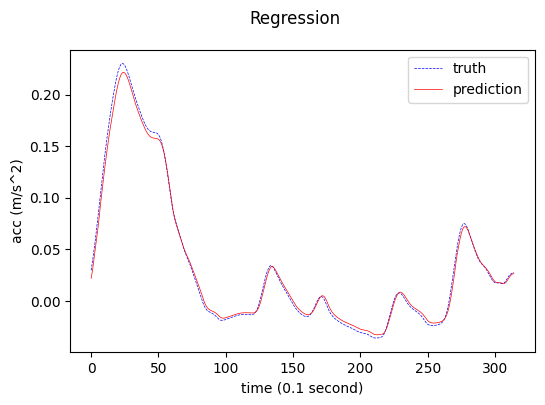

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00004178


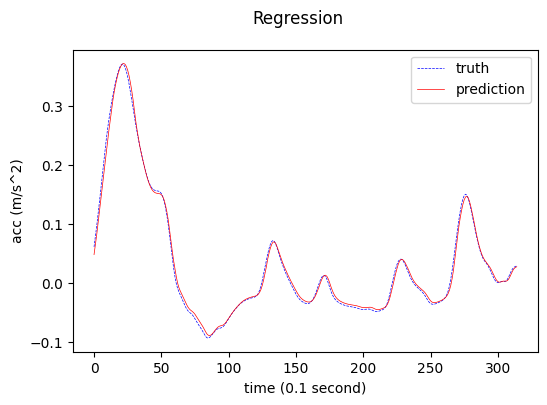

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00002339


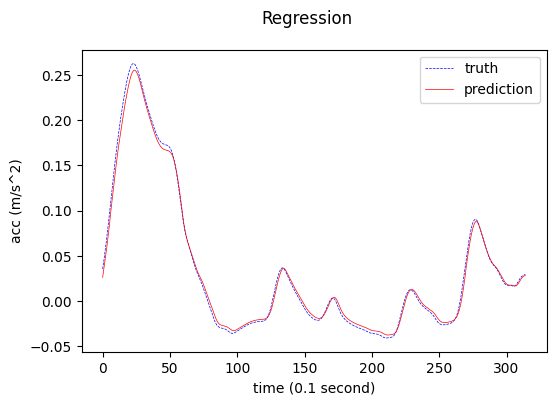

torch.Size([315, 5, 3])
torch.Size([315, 5, 1])
MSE Loss total: 0.00001956


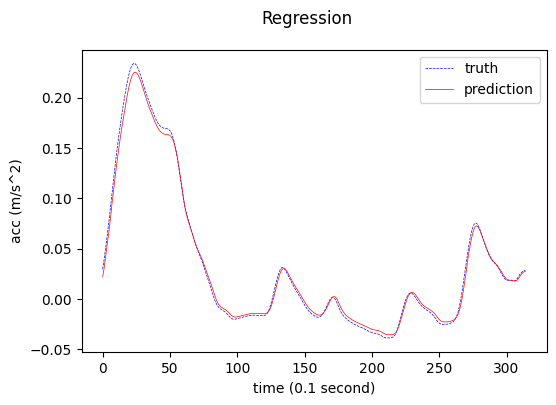

average MSE loss: 2.4794401397230104e-05


In [8]:
MSE = []
num_test = testing_size
#test
test_X = Variable(torch.empty(sample_len, seq_length, 14))
test_Y = Variable(torch.empty(sample_len, seq_length, 2))

for k in range(testing_size):
    test_X = testX[k*sample_len:k*sample_len+sample_len]
    test_Y = testY[k*sample_len:k*sample_len+sample_len]

    print(test_X.shape)
    print(test_Y.shape)

    test_X = test_X.to(device)
    test_Y = test_Y.to(device)
    
    ##########################################
    model.eval()

    predict = model(test_X, test_Y[:,:-1,:])
    
    data_predict = np.zeros((sample_len))
    data_test = np.zeros((sample_len))

    for i in range(sample_len):
        data_predict[i] = predict[i]  

    #predict_total = rnn(test_X)
    loss_t = criterion(predict, test_Y[:,4,:].reshape(-1,output_size))
    print("MSE Loss total: %1.8f" % (loss_t.item()))
    MSE.append(loss_t.item()) 
    
    data_test = test_Y[:,4,0].cpu().data.numpy()

    plt.figure(dpi=100)
    plt.plot(data_test,c='b', linewidth=0.5, label = 'truth', linestyle='dashed')
    plt.plot(data_predict,c='r', linewidth=0.5, label = 'prediction')
    plt.xlabel('time (0.1 second)')
    plt.ylabel('acc (m/s^2)')
    plt.suptitle('Regression')
    plt.legend()
    plt.show()

print('average MSE loss:', sum(MSE)/num_test)

In [9]:
quit()